#### Initailization

In [7]:
desc = {
    "macro_area_ratio": "the ratio of total macros area in the layout",
    "mean_macro_edge_length": "the edge length of all macros calculated by average",
    "mean_macro_neighbor_distance": "the total near distances of macros calculated by average",
    "min_rudy": "the minimum value of the rudy map",
    "max_rudy": "the maximum value of the rudy map",
    "mean_rudy": "the average of the rudy map",
    "std_rudy": "the standard deviation of the rudy map",
    "PAR_rudy": "the Peak-to-Average Ratio of the rudy map",
    "high_density_rudy_ratio": "the ratio of hotspots area in the rudy map",
    "min_rudy_pin": "the minimum value of the rudy pin map",
    "max_rudy_pin": "the maximum value of the rudy pin map",
    "mean_rudy_pin": "the average of the rudy pin map",
    "std_rudy_pin": "the standard deviation of the rudy pin map",
    "PAR_rudy_pin": "the Peak-to-Average Ratio of the rudy pin map",
    "high_density_rudy_pin_ratio": "the ratio of hotspots area in the rudy pin map",
}

In [1]:
feat_func_list = []

In [2]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [ ]:
api_key = "sk-your_api_key_here"

def encode_image(features):
    features_b64 = []
    for image in features:
        buff = BytesIO()
        image.save(buff, format="PNG")
        buff.seek(0)
        image_b64 = base64.b64encode(buff.read()).decode()
        features_b64.append(image_b64)
    return features_b64

headers = {
  "Content-Type": "application/json",
  "Authorization": f"Bearer {api_key}"
}

In [4]:
import models
device = "cuda:4"
opt = {'task': 'congestion_gpdl', 'save_path': 'work_dir/congestion_gpdl/', 'pretrained': '/home/felixchaotw/CircuitNet/model/congestion.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/congestion', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'CongestionDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'GPDL', 'in_channels': 3, 'out_channels': 1, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["GPDL"](**opt)
model.init_weights(**opt)
model.to(device)

/home/felixchaotw/mllm-physical-design/feat_extract/models/gpdl.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(pretrained, map_location='cpu')['st

GPDL(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

In [5]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [92]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq


tile_size = 16
top_k = 20
image_size = 256


def get_tiles_congestion(image_array):
    tiles = []
    for x in range(0, image_size, tile_size):
        for y in range(0, image_size, tile_size):
            tile = image_array[x:x+tile_size, y:y+tile_size]
            tiles.append(np.mean(tile))
            
    tiles = heapq.nlargest(top_k, tiles)
    return tiles

file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/zero-riscy-a/7228-zero-riscy-a-1-c2-u0.9-m2-p4-f0.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/zero-riscy-a/7228-zero-riscy-a-1-c2-u0.9-m2-p4-f0.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    image_features.append(image)
    image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
tiles = get_tiles_congestion(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(np.mean(tiles))

0.4061364462668598


In [ ]:
base64_images = encode_image(image_inferences)

In [93]:
def macro_features(image):
    tiles_size = 2.25
    image_height, image_width = image.shape
    total_image_area = image_width * image_height
    
    image = np.uint8(image*255)
    
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    centroids = []
    total_macros_area = 0
    total_edge_length = 0
    
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        total_macros_area += w * h
        total_edge_length += 2 * (w + h)
        centroid_x = x + w / 2
        centroid_y = y + h / 2
        centroids.append((centroid_x, centroid_y))
    
    neighbor_distances = []
    for i, (x1, y1) in enumerate(centroids):
        min_distance = float("inf")  
        for j, (x2, y2) in enumerate(centroids):
            if i != j: 
                distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
                if distance < min_distance:
                    min_distance = distance
        neighbor_distances.append(min_distance)
    

    if neighbor_distances and num_macros > 1:
        mean_neighbor_distance = sum(neighbor_distances) / len(neighbor_distances)
    else:
        mean_neighbor_distance = 0.0
 
    
    return {
            "mean_macro_neighbor_distance": float(mean_neighbor_distance * tiles_size),
            "macro_area_ratio": total_macros_area / total_image_area,
            "mean_macro_edge_length": (total_edge_length / num_macros) * tiles_size,
        }

In [94]:
def rudy_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy": mean_rudy,
        "std_rudy": std_rudy,
        "PAR_rudy": par_rudy,
        "high_density_rudy_ratio": high_density_rudy_ratio,
    }

In [95]:
def rudy_pin_features(image):
    total_area = image.shape[0] * image.shape[1]
    max_rudy = np.max(image)
    min_rudy = np.min(image)
    mean_rudy = np.mean(image)
    std_rudy = np.std(image)
    par_rudy = max_rudy / mean_rudy
    high_density_rudy_ratio = (image > mean_rudy).sum() /  total_area
    
    return {
        "mean_rudy_pin": mean_rudy,
        "std_rudy_pin": std_rudy,
        "PAR_rudy_pin": par_rudy,
        "high_density_rudy_pin_ratio": high_density_rudy_ratio,
    }

In [96]:
def get_all_features(images):
    macro_feature = images[0]
    rudy_feature = images[1]
    rudy_pin_feature = images[2]
    
    mf = macro_features(macro_feature)
    rf = rudy_features(rudy_feature)
    rpf = rudy_pin_features(rudy_pin_feature)
    
    final_features = {**mf, **rf, **rpf}
    
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

#### Fitness Scoring

In [97]:
get_all_features(image_features)

{'mean_macro_neighbor_distance': 0.0,
 'macro_area_ratio': 0.55419921875,
 'mean_macro_edge_length': 1741.5,
 'mean_rudy': np.float64(0.15478117255206314),
 'std_rudy': np.float64(0.14191670718407573),
 'PAR_rudy': np.float64(6.460734102938998),
 'high_density_rudy_ratio': np.float64(0.492401123046875),
 'mean_rudy_pin': np.float64(0.13647938888563046),
 'std_rudy_pin': np.float64(0.12887029229064226),
 'PAR_rudy_pin': np.float64(7.327113699475887),
 'high_density_rudy_pin_ratio': np.float64(0.2754974365234375),
 'rudy_gradient_variability': np.float64(0.21716131475275102),
 'clustered_macro_distance_std': 0.0,
 'rudy_pin_clustering_coefficient': 0.6045845272206304,
 'macro_density_gradient': np.float64(862.029802160665),
 'macro_aspect_ratio_variance': np.float64(0.0),
 'macro_compactness_index': 3.7332329519145655,
 'rudy_pin_compaction_ratio': 0.44073884043099026,
 'macro_variability_coefficient': np.float64(0.0),
 'macro_symmetry_coefficient': 0.5938061749030243,
 'macro_cluster_de

In [98]:
import pandas as pd
from tqdm import tqdm
import os
import torch


def dataset_setting(designs):
    df_list = []
    for design in designs:
        feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/{design}/" 
        label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/{design}/"

        labels = []
        ids = []

        for filename in tqdm(os.listdir(label_path)):
            file_path = os.path.join(label_path, filename)
            label_image = np.load(file_path).squeeze()
            label = float(np.mean(get_tiles_congestion(label_image)))
            ids.append(filename)
            labels.append(label)
            
        df = pd.DataFrame({"id": ids,})

        for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value
            
            with torch.no_grad():
                input_image = torch.tensor(batch_image).unsqueeze(0).float().to(device)
                output_image = model(input_image)
                prediction = np.mean(get_tiles_congestion(output_image.cpu().numpy().squeeze()))
            
            df.loc[index, "prediction_gpdl"] = prediction
        
        df['label'] = labels
        df_list.append(df)
        
    return pd.concat(df_list)

In [ ]:
train_df = dataset_setting(train_design)
test_df_a = dataset_setting(test_design_a)
test_df_b = dataset_setting(test_design_b)

100%|██████████| 1122/1122 [02:17<00:00,  8.14it/s]


In [93]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]

In [100]:
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]

In [95]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

x = train_df.drop(columns=["id", "label", "prediction_gpdl"])
y = train_df["label"]
regressor = RandomForestRegressor(random_state=18, max_depth=10, n_estimators=1000)
regressor.fit(x, y)

RandomForestRegressor(max_depth=10, n_estimators=1000, random_state=18)

Text(0, 0.5, 'Feature')

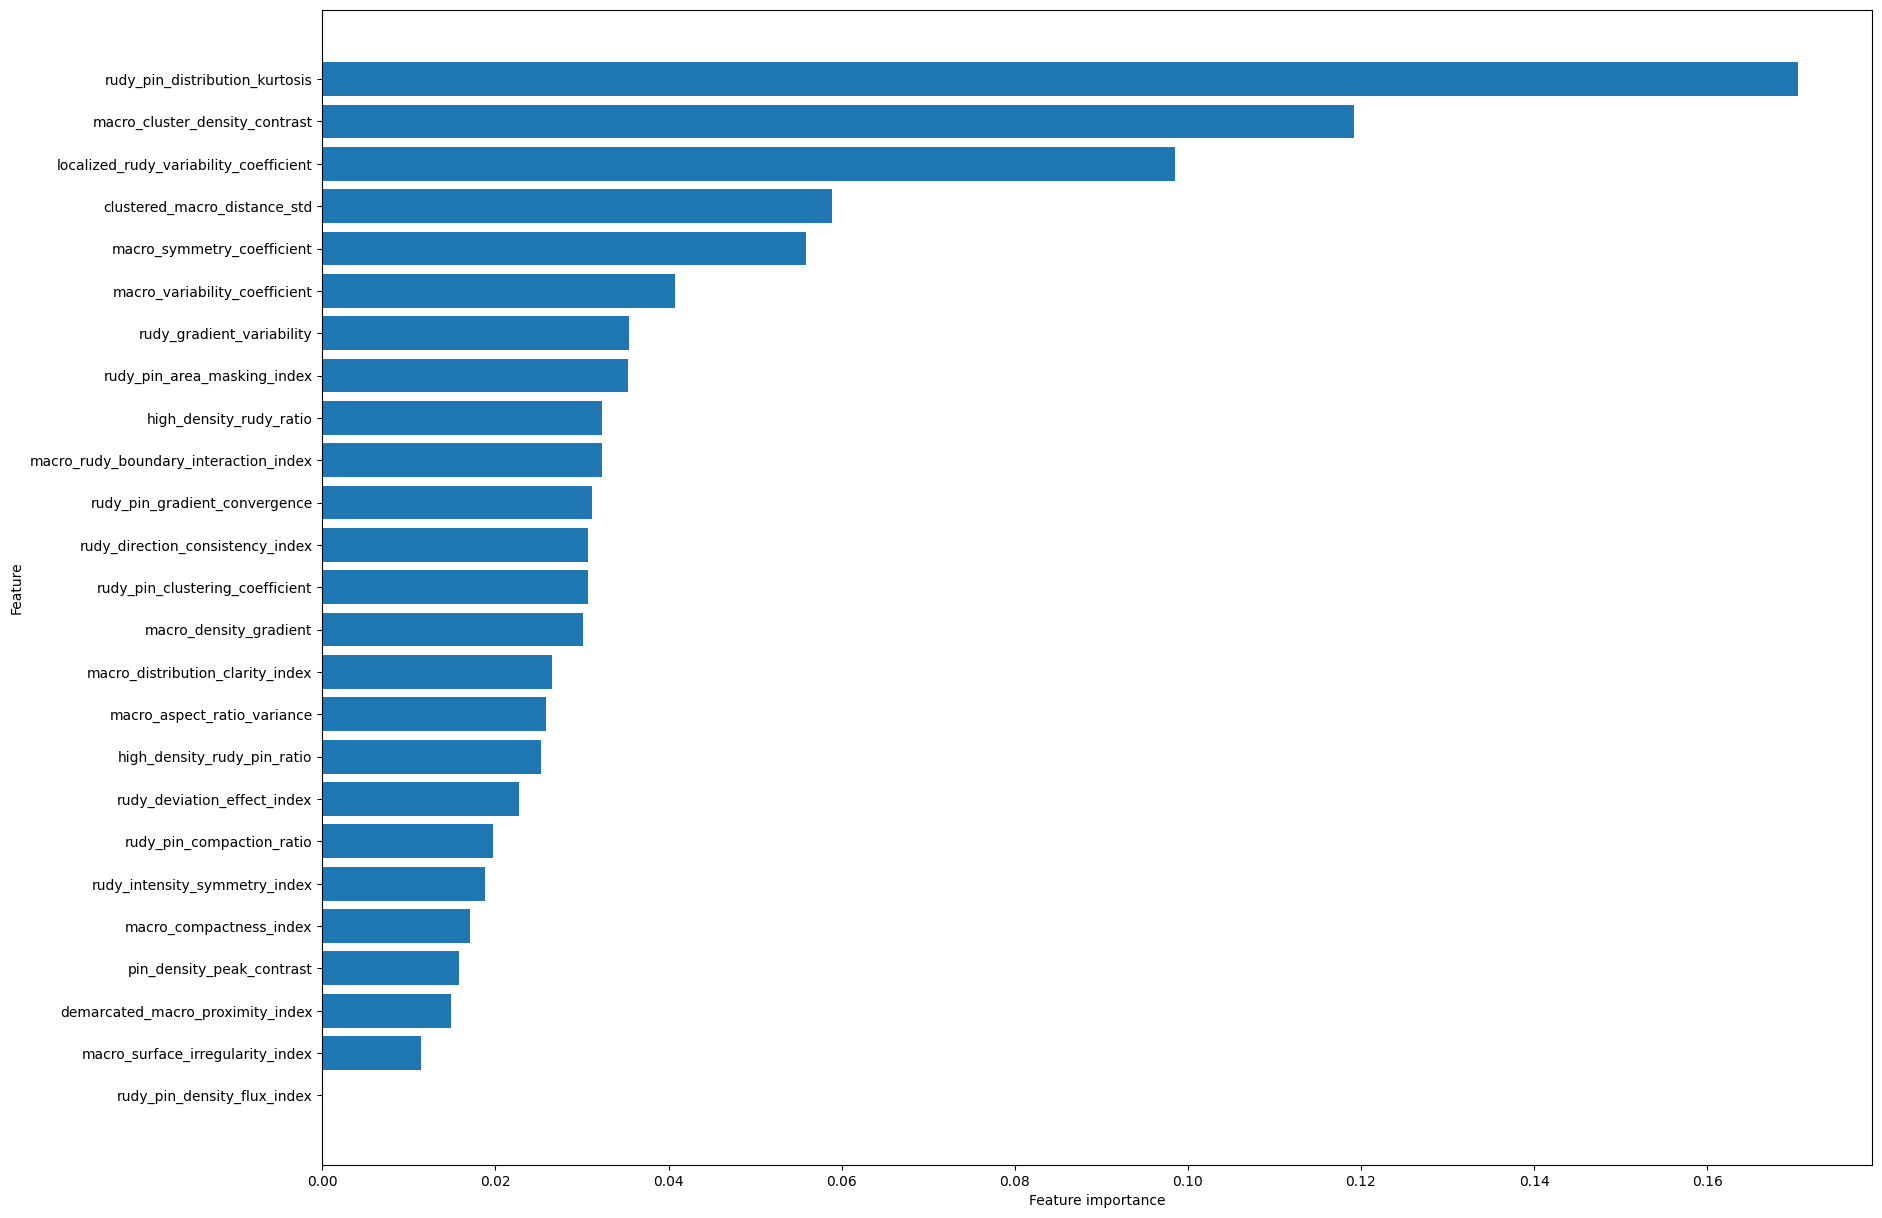

In [96]:
feature_importance = regressor.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

In [ ]:
y_hat_a = regressor.predict(test_df_a.drop(columns=["id", "label", "prediction_gpdl"]))
y_hat_b = regressor.predict(test_df_b.drop(columns=["id", "label", "prediction_gpdl"]))
# Undo the comment to use the GP-DL ensemble predictions
# test_df_a["prediction"] = (y_hat_a + test_df_a["prediction_gpdl"]) / 2
# test_df_b["prediction"] = (y_hat_b + test_df_b["prediction_gpdl"]) / 2
test_df_a["prediction"] = y_hat_a
test_df_b["prediction"] = y_hat_b

In [ ]:
from scipy import stats
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler()

def evalute_corr(congestion_set, predicted, corr_metrics):
    x = np.array(list(congestion_set.values()))
    x = min_max_scaler.fit_transform(x.reshape(-1, 1)).reshape(-1)
    predicted = sorted(predicted.items(), key=lambda x: x[1])
    y = np.array([congestion_set[file_path] for file_path, _ in predicted])
    y = min_max_scaler.fit_transform(y.reshape(-1, 1)).reshape(-1)
    x = x[::10]
    y = y[::10]
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evalute_ndcg(congestion_set, predicted):
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[0]))
    x = np.array(list(congestion_set.values()))
    predicted = dict(sorted(predicted.items(), key=lambda x: x[0]))
    y = np.array(list(predicted.values()))
    return ndcg_score([x], [y])

def evaluate_design(df):
    congestion_set = dict(zip(df["id"], df["label"]))
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction_gpdl"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(congestion_set, predicted, corr_metrics)
    results["NDCG"] = evalute_ndcg(congestion_set, predicted)
    x = list(congestion_set.values())
    y = [predicted[file_path] for file_path in congestion_set.keys()]
    plt.scatter(x, y, s=1)
    plt.scatter(x, x, color="red", s=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predicted")
    plt.title("GPDL")
    plt.savefig("GPDL_GARF.png")
    return results

#### Baseline

{'PLCC': PearsonRResult(statistic=np.float64(0.5033822872732978), pvalue=np.float64(1.253189023833933e-131)),
 'SRCC': SignificanceResult(statistic=np.float64(0.48659732409427214), pvalue=np.float64(7.306734337433144e-122)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3413544897472431), pvalue=np.float64(3.1059649061677342e-118)),
 'NDCG': np.float64(0.9748941165357773)}

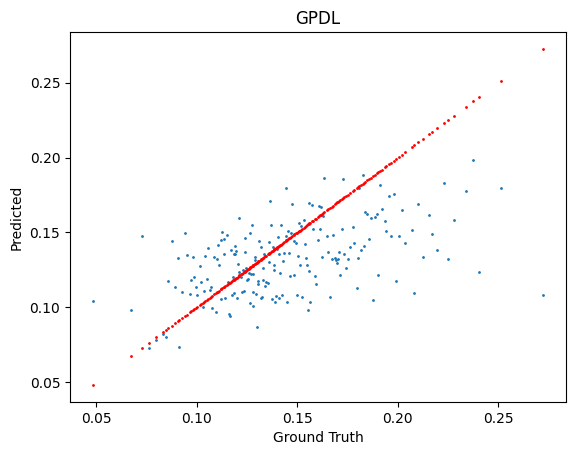

In [109]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.4864604365884569), pvalue=np.float64(1.0380388346272697e-67)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4586753318818432), pvalue=np.float64(1.8514147018039687e-59)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3331806433655414), pvalue=np.float64(1.1035291285788901e-62)),
 'NDCG': np.float64(0.9746814003173546)}

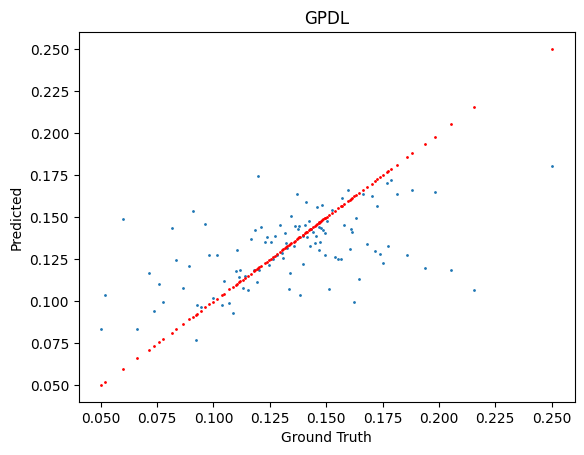

In [110]:
evaluate_design(test_df_b)

#### Stage 1.

{'PLCC': PearsonRResult(statistic=np.float64(0.5033822872732978), pvalue=np.float64(1.253189023833933e-131)),
 'SRCC': SignificanceResult(statistic=np.float64(0.48659732409427214), pvalue=np.float64(7.306734337433144e-122)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3413544897472431), pvalue=np.float64(3.1059649061677342e-118)),
 'NDCG': np.float64(0.9748941165357773)}

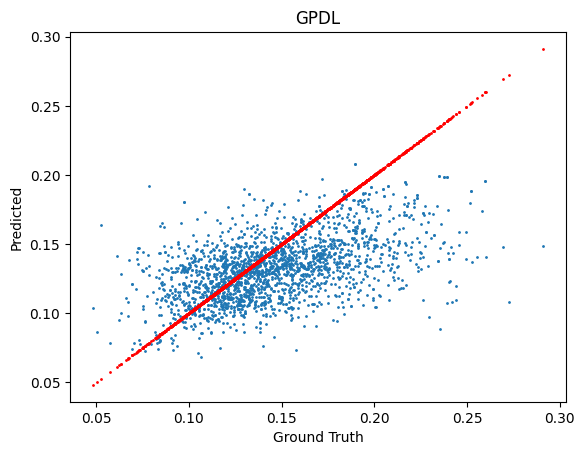

In [106]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.4864604365884569), pvalue=np.float64(1.0380388346272697e-67)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4586753318818432), pvalue=np.float64(1.8514147018039687e-59)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3331806433655414), pvalue=np.float64(1.1035291285788901e-62)),
 'NDCG': np.float64(0.9746814003173546)}

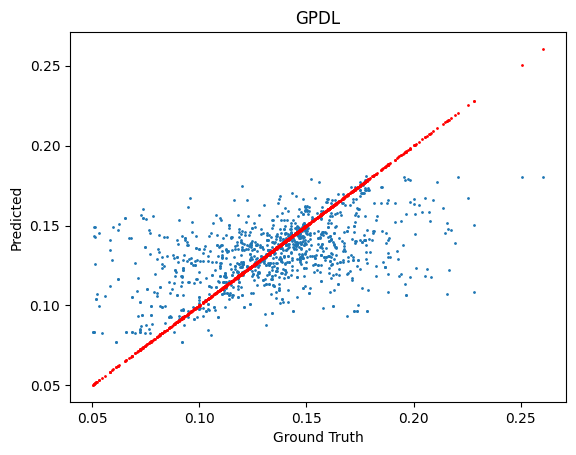

In [107]:
evaluate_design(test_df_b)

#### Stage 2.

In [270]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.0933169472349129), pvalue=np.float64(2.4054943889661097e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.10420408073145539), pvalue=np.float64(2.3724776511880435e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.06994736970919689), pvalue=np.float64(2.1692337329150746e-06)),
 'NDCG': np.float64(0.9509920680802647)}

In [271]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.05798265373706123), pvalue=np.float64(0.05217689968266534)),
 'SRCC': SignificanceResult(statistic=np.float64(0.0691679506092675), pvalue=np.float64(0.020500401251229535)),
 'KRCC': SignificanceResult(statistic=np.float64(0.04214720267207443), pvalue=np.float64(0.03452889595377412)),
 'NDCG': np.float64(0.9497816845440086)}

#### Stage 3.

In [304]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.11839062020094432), pvalue=np.float64(8.072645103459987e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.10199740849975329), pvalue=np.float64(3.868297506853815e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.06878409967266233), pvalue=np.float64(3.189802090550631e-06)),
 'NDCG': np.float64(0.9574717236712927)}

In [305]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.14083609664485908), pvalue=np.float64(2.1814096036312845e-06)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13188011229638347), pvalue=np.float64(9.338976181844719e-06)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0903113443874508), pvalue=np.float64(5.913658562442322e-06)),
 'NDCG': np.float64(0.9532821043237293)}

#### Stage 4.

In [356]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.11915637396902806), pvalue=np.float64(6.6473906289751e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12087944861914335), pvalue=np.float64(4.2745281179799184e-08)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08126909689645888), pvalue=np.float64(3.718723083084704e-08)),
 'NDCG': np.float64(0.9546669956991163)}

In [357]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.10848416215883094), pvalue=np.float64(0.00027209525842130516)),
 'SRCC': SignificanceResult(statistic=np.float64(0.08771769615744109), pvalue=np.float64(0.0032756653620218605)),
 'KRCC': SignificanceResult(statistic=np.float64(0.058604318263151614), pvalue=np.float64(0.0032903242047760367)),
 'NDCG': np.float64(0.953665291642964)}

#### Stage 5.

In [388]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.13139666501680336), pvalue=np.float64(2.5248842386965006e-09)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12110528464798737), pvalue=np.float64(4.0323340298375315e-08)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0820801226232507), pvalue=np.float64(2.7188712319960654e-08)),
 'NDCG': np.float64(0.9542199986314785)}

In [389]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.11849689114120458), pvalue=np.float64(6.926246553916523e-05)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11244785900265943), pvalue=np.float64(0.00016041788533408785)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07678396755338185), pvalue=np.float64(0.00011763444936921371)),
 'NDCG': np.float64(0.9547581628632205)}

#### Stage 6

In [449]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1694216964842366), pvalue=np.float64(1.2880888383935732e-14)),
 'SRCC': SignificanceResult(statistic=np.float64(0.17542184371665515), pvalue=np.float64(1.4145701465733354e-15)),
 'KRCC': SignificanceResult(statistic=np.float64(0.11901778545826072), pvalue=np.float64(7.62104017969493e-16)),
 'NDCG': np.float64(0.9551542055821112)}

In [450]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.10108191824046275), pvalue=np.float64(0.0006969377467138213)),
 'SRCC': SignificanceResult(statistic=np.float64(0.09942238459453236), pvalue=np.float64(0.0008535084741083005)),
 'KRCC': SignificanceResult(statistic=np.float64(0.06666984770766234), pvalue=np.float64(0.0008265621593380056)),
 'NDCG': np.float64(0.9546364950218827)}

#### Stage 7

In [487]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15469618414450848), pvalue=np.float64(2.086815735695268e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15366850001833648), pvalue=np.float64(2.924621536787148e-12)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10410690950728507), pvalue=np.float64(1.7848260161171729e-12)),
 'NDCG': np.float64(0.9554802528764672)}

In [488]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.07925077237060682), pvalue=np.float64(0.007911483292329737)),
 'SRCC': SignificanceResult(statistic=np.float64(0.06983428745555671), pvalue=np.float64(0.01931281848973912)),
 'KRCC': SignificanceResult(statistic=np.float64(0.04745636009384071), pvalue=np.float64(0.01730725283649344)),
 'NDCG': np.float64(0.949442421154019)}

#### Stage 8

In [531]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15955241698155803), pvalue=np.float64(4.105962081337775e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.1693365254558789), pvalue=np.float64(1.328360170516163e-14)),
 'KRCC': SignificanceResult(statistic=np.float64(0.11479709240078492), pvalue=np.float64(7.586543505686461e-15)),
 'NDCG': np.float64(0.953080233232511)}

In [532]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.11061692395663202), pvalue=np.float64(0.00020520384886295575)),
 'SRCC': SignificanceResult(statistic=np.float64(0.08530268757872005), pvalue=np.float64(0.004245103700349727)),
 'KRCC': SignificanceResult(statistic=np.float64(0.05725396636049147), pvalue=np.float64(0.004085269996289477)),
 'NDCG': np.float64(0.9510821827861993)}

#### Stage 9

In [579]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.12376454755577998), pvalue=np.float64(2.0128506618687733e-08)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12734186011347579), pvalue=np.float64(7.723451103278008e-09)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0862062759954141), pvalue=np.float64(5.280887297163865e-09)),
 'NDCG': np.float64(0.9524367377274482)}

In [580]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.08827151984858583), pvalue=np.float64(0.0030838995523696684)),
 'SRCC': SignificanceResult(statistic=np.float64(0.05015716663835093), pvalue=np.float64(0.09310095137347284)),
 'KRCC': SignificanceResult(statistic=np.float64(0.03431229869974949), pvalue=np.float64(0.0852706760209872)),
 'NDCG': np.float64(0.9500460515843151)}

#### Stage 10

In [618]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14002992696739533), pvalue=np.float64(2.0815277576582494e-10)),
 'SRCC': SignificanceResult(statistic=np.float64(0.13931923420799944), pvalue=np.float64(2.571509103613839e-10)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09469469200458205), pvalue=np.float64(1.4275498337891454e-10)),
 'NDCG': np.float64(0.9536111035435486)}

In [619]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.09281377410819905), pvalue=np.float64(0.001857178249550994)),
 'SRCC': SignificanceResult(statistic=np.float64(0.07224890522835245), pvalue=np.float64(0.015497687954243852)),
 'KRCC': SignificanceResult(statistic=np.float64(0.04865243150821106), pvalue=np.float64(0.014683110936558318)),
 'NDCG': np.float64(0.9507389751665607)}

#### Stage 11

In [875]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15790560688719088), pvalue=np.float64(7.166928425246573e-13)),
 'SRCC': SignificanceResult(statistic=np.float64(0.15217968019447659), pvalue=np.float64(4.749842445817812e-12)),
 'KRCC': SignificanceResult(statistic=np.float64(0.10282030597265258), pvalue=np.float64(3.3261167698186793e-12)),
 'NDCG': np.float64(0.9562216274573463)}

In [876]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.1388845962141568), pvalue=np.float64(3.0181952041640526e-06)),
 'SRCC': SignificanceResult(statistic=np.float64(0.10740108473706819), pvalue=np.float64(0.0003134120459698491)),
 'KRCC': SignificanceResult(statistic=np.float64(0.07002425543759196), pvalue=np.float64(0.00044478260121333965)),
 'NDCG': np.float64(0.9531600241692576)}

#### Stage 12

In [913]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.14834482024201168), pvalue=np.float64(1.6204787593243625e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14259562322735064), pvalue=np.float64(9.617878103001157e-11)),
 'KRCC': SignificanceResult(statistic=np.float64(0.09633018057079894), pvalue=np.float64(6.860188601325756e-11)),
 'NDCG': np.float64(0.9555992962140696)}

In [911]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.15175885156504498), pvalue=np.float64(3.2679904914083377e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.12150725646955313), pvalue=np.float64(4.491358429128059e-05)),
 'KRCC': SignificanceResult(statistic=np.float64(0.08169549485068989), pvalue=np.float64(4.179324200814994e-05)),
 'NDCG': np.float64(0.9550903434000357)}

#### Stage 13

In [945]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.15275818347445114), pvalue=np.float64(3.93631315253942e-12)),
 'SRCC': SignificanceResult(statistic=np.float64(0.14495235437689105), pvalue=np.float64(4.674457860764637e-11)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0977338789440925), pvalue=np.float64(3.6226400304830993e-11)),
 'NDCG': np.float64(0.9562824050716134)}

In [946]:
evaluate_design(test_df_b)

{'PLCC': PearsonRResult(statistic=np.float64(0.1503707943398236), pvalue=np.float64(4.1916221576679155e-07)),
 'SRCC': SignificanceResult(statistic=np.float64(0.11457617320416658), pvalue=np.float64(0.000119930023262481)),
 'KRCC': SignificanceResult(statistic=np.float64(0.0764245099208716), pvalue=np.float64(0.00012660224927545392)),
 'NDCG': np.float64(0.9554108415542337)}

#### Genetic Algorithm

In [204]:
feat_importances = feature_importance[sorted_idx][-20:]
feat_pool = list(x.columns[sorted_idx])[-20:]

In [ ]:
def forget_curve(t, S=20):
    return np.exp(-t/S)

In [ ]:
feat_importances = {feat: imp for feat, imp in zip(feat_pool, feat_importances)}
feat_pool = {feat: desc[feat] for feat in feat_pool}
n = len(feat_pool)
feat_importances = {feat: forget_curve(n - i, n) for i, feat in enumerate(feat_importances.keys())}

In [67]:
import re
import requests
from prompt import CROSS_OVER_PROMPT, MUTATION_PROMPT, DEDUPLICATION_PROMPT, CODE_GEN_PROMPT

def prompt_selection(task_id, desc, feat_pool, feat_importances):
    if task_id == 0:
        prompts = [CROSS_OVER_PROMPT.format(existing_features=desc, feat_pool=feat_pool)]
    else:
        pd = np.random.uniform(0, 1, len(feat_importances))
        prompts = []
        for i, (feat, imp) in enumerate(feat_importances.items()):
            if pd[i] < imp:
                feat = {feat: desc[feat]}
                mutated_prompt = MUTATION_PROMPT.format(existing_features=desc, feature=feat)
                prompts.append(mutated_prompt)
    return prompts

def mllm_single_inference(prompt, type="json"):
    payload = {
    "model": "gpt-4o",
    "messages": [
        {
        "role": "user",
        "content": [
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[0]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[1]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[2]}"
            }
            },
            {
            "type": "image_url",
            "image_url": {
                "url": f"data:image/jpeg;base64,{base64_images[3]}"
            }
            },
            {
            "type": "text",
            "text": prompt,
            }
        ]
        }
    ],
    "max_tokens": 2000,
    }

    response = requests.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
    response = response.json()['choices'][0]['message']['content'] 
    pattern = r"```json([\s\S]*?)```" if type == "json" else r"```python([\s\S]*?)```"
    response = re.search(pattern, response).group(1).strip()
    print(response)
    return response

def feat_extractor(task_id, responses):
    if task_id == 0:
        new_feat = json.loads(responses[0])
    else:
        new_feat = {}
        for response in responses:
            new_feat.update(json.loads(response))
            
    return new_feat

def featgen_inference(prompts):
    responses = []
    for prompt in prompts:
        response = mllm_single_inference(prompt)
        responses.append(response)
    return responses

def deduplicator(feat_pool, new_feat):
    prompt = DEDUPLICATION_PROMPT.format(feat_pool=feat_pool, new_feat_pool=new_feat)
    response = mllm_single_inference(prompt)
    response = json.loads(response)
    dup_feat = [r["feature"] for r in response]
    no_dup_feat = {k: v for k, v in new_feat.items() if k not in dup_feat}
    return no_dup_feat

def code_gen(new_feats):
    responses = []
    for new_feat, definition in new_feats.items():
        prompt = CODE_GEN_PROMPT.format(feature={new_feat: definition}, feature_name=new_feat)
        response = mllm_single_inference(prompt, type="python")
        responses.append(response)
    return responses

In [68]:
task_ids ={0: "cross-over", 1: "mutation"}
task_prob =[0.5, 0.5] 

def genetic_instruct(feat_pool, feat_importances):
    task_id = np.random.choice(list(task_ids.keys()), p=task_prob)
    print(f"Task: {task_ids[task_id]}")
    prompts = prompt_selection(task_id, desc, feat_pool, feat_importances)
    responses = featgen_inference(prompts)
    new_feats = feat_extractor(task_id, responses)
    no_dup_feat = deduplicator(desc, new_feats)
    return no_dup_feat

In [968]:
new_feat_pool = genetic_instruct(feat_pool, feat_importances)

Task: mutation
{
  "rudy_pin_boundary_pressure_gradient": "a measure of the change in pressure exerted by rudy pins at macro boundaries, indicating potential stress points for routing paths and congestion adaptation"
}
{
  "rudy_intensity_asymmetry_coefficient": "the measure of the degree of asymmetry in RUDY intensity distribution across the layout, identifying areas of potential imbalanced routing demand"
}
{
  "edge_macro_overlap_index": "a measure of the extent to which macro edges overlap with high-density RUDY edge regions, indicating potential edge congestion points"
}
{
  "rudy_pin_distribution_smoothness": "a measure of how smoothly rudy pins are distributed across the layout, indicating potential areas of gradual routing demand transition"
}
{
  "rudy_pin_density_gradient_shift": "a measure of the shift in density gradients between regions of high rudy pin concentration and their adjacent areas, indicating potential boundary-driven changes in routing demand"
}
{
  "rudy_asymm

In [969]:
new_feat_pool

{'rudy_pin_boundary_pressure_gradient': 'a measure of the change in pressure exerted by rudy pins at macro boundaries, indicating potential stress points for routing paths and congestion adaptation',
 'edge_macro_overlap_index': 'a measure of the extent to which macro edges overlap with high-density RUDY edge regions, indicating potential edge congestion points',
 'rudy_pin_distribution_smoothness': 'a measure of how smoothly rudy pins are distributed across the layout, indicating potential areas of gradual routing demand transition',
 'rudy_pin_density_gradient_shift': 'a measure of the shift in density gradients between regions of high rudy pin concentration and their adjacent areas, indicating potential boundary-driven changes in routing demand',
 'rudy_pin_distribution_entropy': 'a measure of the randomness or disorder in the distribution of rudy pins across the layout, indicating potential unpredictability in routing demand patterns',
 'rudy_pin_cluster_periphery_density': 'the de

In [72]:
error_code = {
 'rudy_pin_distribution_smoothness': 'a measure of how smoothly rudy pins are distributed across the layout, indicating potential areas of gradual routing demand transition',
}
code_feat = code_gen(error_code)
# code_feat = code_gen(new_feat_pool)

import cv2
import numpy as np

def rudy_pin_distribution_smoothness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the smoothness of RUDY pin distribution
    blurred_image = cv2.GaussianBlur(rudy_pin_image, (7, 7), 1.5)  # Apply Gaussian Blur
    smoothness = np.var(blurred_image)  # Calculate variance as a measure of smoothness

    return {"rudy_pin_distribution_smoothness": smoothness}

# Example usage:
# Load images as grayscale numpy arrays
# images = [macro_image, rudy_image, rudy_pin_image]
# result = rudy_pin_distribution_smoothness(images)
# print(result)


#### Stage 1 Function

In [50]:
def macro_intersection_density(images):
    import cv2
    import numpy as np

    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8 and binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Define RUDY high-density regions as those with values above a threshold
    rudy_thresh = 0.5  # example threshold for high density 
    rudy_high_density = (rudy_image > rudy_thresh).astype(np.uint8)
    
    # Find macro intersections with RUDY high-density regions
    macro_intersections = 0
    for contour in contours:
        mask = np.zeros_like(macro_image, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        intersection = cv2.bitwise_and(mask, mask, mask=rudy_high_density * 255)
        if cv2.countNonZero(intersection) > 0:
            macro_intersections += 1

    # Calculate the density of macro intersections
    feature_value = (macro_intersections * tiles_size) / (total_image_area * tiles_size)
    
    return {"macro_intersection_density": feature_value}


def rudy_gradient_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute gradients using the Sobel operator
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(grad_x, grad_y)

    # Calculate gradient variability
    gradient_variability = np.var(magnitude)

    feature_value = gradient_variability * (tiles_size ** 2)  # Convert to um^2

    return {"rudy_gradient_variability": feature_value}

def macro_perimeter_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert the macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total perimeter length of macros
    macro_perimeter = 0
    for contour in contours:
        macro_perimeter += cv2.arcLength(contour, True)
    
    # Convert pixel perimeter length to micrometers
    macro_perimeter_um = macro_perimeter * tiles_size
    
    # Calculate the perimeter length of the entire image
    layout_perimeter_um = (2 * (256 * tiles_size) + 2 * (256 * tiles_size))
    
    # Calculate the macro perimeter ratio
    macro_perimeter_ratio = macro_perimeter_um / layout_perimeter_um
    
    return {"macro_perimeter_ratio": macro_perimeter_ratio}


def clustered_macro_distance_std(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate centers of mass for each contour (macro)
    centers = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centers.append((cX, cY))

    # Calculate pairwise distances
    distances = []
    num_centers = len(centers)
    for i in range(num_centers):
        for j in range(i + 1, num_centers):
            dist = np.sqrt((centers[i][0] - centers[j][0]) ** 2 + (centers[i][1] - centers[j][1]) ** 2)
            distances.append(dist * tiles_size)  # Convert pixel distance to um

    # Calculate standard deviation of distances
    if distances:
        std_distance = np.std(distances)
    else:
        std_distance = 0.0
    
    return {"clustered_macro_distance_std": std_distance}


def macro_proximity_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Detect high-density Rudy pin areas (assuming high density is > 0.5)
    high_density_mask = rudy_pin_image > 0.5
    
    # Calculate proximity variance
    distances = []
    for contour in contours:
        # Compute the centroid of each macro
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            
            # Find the distance to the nearest high-density Rudy area
            distances_to_high_density = []
            for i in range(high_density_mask.shape[0]):
                for j in range(high_density_mask.shape[1]):
                    if high_density_mask[i, j]:
                        dist = np.sqrt((cX - j) ** 2 + (cY - i) ** 2)
                        distances_to_high_density.append(dist)
            
            if distances_to_high_density:
                nearest_distance = min(distances_to_high_density)
                # Convert distance to micrometers
                distances.append(nearest_distance * tiles_size)
    
    variance = np.var(distances) if distances else 0
    
    return {"macro_proximity_variance": variance}

In [51]:
new_feat_func_list = [macro_intersection_density, rudy_gradient_variability, macro_perimeter_ratio, clustered_macro_distance_std, macro_proximity_variance]

In [52]:
feat_func_list = new_feat_func_list

In [53]:
desc.update(new_feat_pool)

NameError: name 'new_feat_pool' is not defined

#### Stage 2 Function

In [54]:
import cv2
import numpy as np

def rudy_pin_clustering_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Convert rudy_pin_image to binary
    _, rudy_pin_binary = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    
    # Find contours of the rudy pins
    contours, _ = cv2.findContours(rudy_pin_binary.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    total_rudy_pins = len(contours)
    clustered_rudy_pins = 0
    
    # Calculate the clustering coefficient
    for contour in contours:
        if len(contour) > 1:
            clustered_rudy_pins += 1
            
    clustering_coefficient = clustered_rudy_pins / total_rudy_pins if total_rudy_pins > 0 else 0
    
    return {"rudy_pin_clustering_coefficient": clustering_coefficient}


def macro_connectivity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialize feature value
    connectivity_count = 0
    
    # Analyze bounding rectangles for each contour to find direct neighbors
    bounding_boxes = [cv2.boundingRect(contour) for contour in contours]
    
    # Check for connections between bounding boxes
    for i, (x1, y1, w1, h1) in enumerate(bounding_boxes):
        for j, (x2, y2, w2, h2) in enumerate(bounding_boxes):
            if i != j:
                # Check for adjacency (consider the margins as connected)
                if (abs(x1 - x2) <= tiles_size and (y1 <= y2 <= y1 + h1 or y2 <= y1 <= y2 + h2)) or \
                   (abs(y1 - y2) <= tiles_size and (x1 <= x2 <= x1 + w1 or x2 <= x1 <= x2 + w2)):
                    connectivity_count += 1
    
    # Each connection is counted twice (one for each direction), divide by 2
    macro_connectivity_index = connectivity_count / 2

    return {"macro_connectivity_index": macro_connectivity_index}


def edge_congestion_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Scale macro image to [0,255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Analyze RUDY image for congestion near edges
    threshold_value = 0.5  # Define what "high density" means, can be adjusted
    edge_band_width = 10   # Example width of edge band in pixels, can be adjusted
    
    # Define edge bands
    left_edge = rudy_image[:, 0:edge_band_width]
    right_edge = rudy_image[:, -edge_band_width:]
    top_edge = rudy_image[0:edge_band_width, :]
    bottom_edge = rudy_image[-edge_band_width:, :]
    
    # Calculate congestion in each edge
    left_congestion = np.sum(left_edge > threshold_value)
    right_congestion = np.sum(right_edge > threshold_value)
    top_congestion = np.sum(top_edge > threshold_value)
    bottom_congestion = np.sum(bottom_edge > threshold_value)

    # Total edge congestion
    total_edge_congestion = left_congestion + right_congestion + top_congestion + bottom_congestion
    
    # Convert pixel area to um^2
    total_edge_congestion_area_um = total_edge_congestion * (tiles_size ** 2)
    total_layout_area_um = total_image_area * (tiles_size ** 2)

    # Calculate edge congestion ratio
    edge_congestion_ratio_value = total_edge_congestion_area_um / total_layout_area_um
    
    return {"edge_congestion_ratio": edge_congestion_ratio_value}

def macro_density_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to get macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate macro density per region
    macro_density = np.zeros((image_height, image_width))
    for contour in contours:
        mask = np.zeros_like(binary_image)
        cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        macro_density += mask

    # Gradient of the macro density
    gradient_x = cv2.Sobel(macro_density, cv2.CV_64F, 1, 0, ksize=5)
    gradient_y = cv2.Sobel(macro_density, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate the magnitude of gradients
    gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)

    # Calculate the average gradient magnitude in micrometers
    macro_density_gradient_um = np.sum(gradient_magnitude) / (image_height * image_width)
    macro_density_gradient_um *= tiles_size  # Convert to micrometers

    return {"macro_density_gradient": macro_density_gradient_um}


def macro_distribution_evenness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8 from [0-1] to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate convex hull of the macros
    hull_area = 0
    for contour in contours:
        hull = cv2.convexHull(contour)
        hull_area += cv2.contourArea(hull)
    
    # Normalize the hull area to (um^2)
    hull_area_um2 = hull_area * (tiles_size ** 2)
    
    # Total layout area in um^2
    total_layout_area_um2 = total_image_area * (tiles_size ** 2)
    
    # Evenness metric
    if total_layout_area_um2 > 0:
        evenness = hull_area_um2 / total_layout_area_um2
    else:
        evenness = 0
    
    return {"macro_distribution_evenness": evenness}


def rudy_pin_sparsity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Convert pixels to um²

    # Convert macro image to [0-255] and find contours
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate RUDY pin density
    rudy_pin_density = np.sum(rudy_pin_image) / total_image_area

    # Calculate RUDY density
    rudy_density = np.sum(rudy_image) / total_image_area

    # Rudy pin sparsity index calculation
    max_possible_density = 1.0  # Considering the normalized image range
    sparsity_index = (max_possible_density - rudy_pin_density) / max_possible_density

    return {"rudy_pin_sparsity_index": sparsity_index}

In [55]:
new_feat_func_list = [rudy_pin_clustering_coefficient, macro_connectivity_index, edge_congestion_ratio, macro_density_gradient, macro_distribution_evenness, rudy_pin_sparsity_index]

In [56]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool.keys())]

In [57]:
feat_func_list = feat_func_list + new_feat_func_list

In [58]:
feat_func_list

[<function __main__.rudy_gradient_variability(images)>,
 <function __main__.clustered_macro_distance_std(images)>,
 <function __main__.rudy_pin_clustering_coefficient(images)>,
 <function __main__.macro_connectivity_index(images)>,
 <function __main__.edge_congestion_ratio(images)>,
 <function __main__.macro_density_gradient(images)>,
 <function __main__.macro_distribution_evenness(images)>,
 <function __main__.rudy_pin_sparsity_index(images)>]

In [59]:
desc.update(new_feat_pool)

NameError: name 'new_feat_pool' is not defined

#### Stage 3 Function

In [60]:
import cv2
import numpy as np

def rudy_pin_to_macro_density_variability(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0, 255] and prepare binary image for contour detection
    macro_image_uint8 = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate densities (sum of pixel values) for each image within the unit square
    macro_density = np.sum(macro_image) / total_image_area
    rudy_density = np.sum(rudy_image) / total_image_area
    rudy_pin_density = np.sum(rudy_pin_image) / total_image_area
    
    # Calculate variability as the standard deviation of densities across different regions
    densities = np.array([macro_density, rudy_density, rudy_pin_density])
    density_variability = np.std(densities)
    
    feature_value = density_variability * (tiles_size ** 2)  # Scale to μm²
    
    return {"rudy_pin_to_macro_density_variability": feature_value}


def macro_aspect_ratio_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert the macro image from [0-1] to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate aspect ratio for each macro and store them
    aspect_ratios = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / float(h)
        aspect_ratios.append(aspect_ratio)
    
    # Calculate the variance of aspect ratios
    aspect_ratio_variance = np.var(aspect_ratios) * (tiles_size ** 2)
    
    # Return the feature
    return {"macro_aspect_ratio_variance": aspect_ratio_variance}


def gradient_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 scale and create binary image
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Detect contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Compute gradients in the RUDY image
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=5)
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Threshold gradient magnitude to find areas of steep gradient
    _, strong_gradients = cv2.threshold(gradient_magnitude, np.max(gradient_magnitude) * 0.5, 1, cv2.THRESH_BINARY)
    
    # Find edges in the macro image
    edges = cv2.Canny(np.uint8(macro_image), 100, 200)
    
    # Calculate alignment index based on overlap of edges and strong gradients
    overlap = cv2.bitwise_and(edges, np.uint8(strong_gradients * 255))
    alignment_score = np.sum(overlap) / np.sum(edges)
    
    # Convert to a feature measure
    feature_value = alignment_score * 100  # Scale for better interpretability
    
    return {"gradient_alignment_index": feature_value}

def rudy_edge_gradient_magnitude(images):
    import cv2
    import numpy as np
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradients on the RUDY image
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Calculate gradient magnitude
    grad_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize to 0-1 range
    grad_magnitude = cv2.normalize(grad_magnitude, None, 0, 1, cv2.NORM_MINMAX)
    
    # Find edges using Canny
    edges = cv2.Canny(np.uint8(rudy_image * 255), 100, 200)
    
    # Compute mean gradient magnitude along edges
    edge_grad_magnitudes = grad_magnitude[edges > 0]
    rudy_edge_gradient_magnitude = np.mean(edge_grad_magnitudes)
    
    # Convert length to um
    rudy_edge_gradient_magnitude_um = rudy_edge_gradient_magnitude * tiles_size
    
    return {"rudy_edge_gradient_magnitude": rudy_edge_gradient_magnitude_um}

def macro_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the macro image to identify macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate RUDY high-density regions (threshold RUDY image for high density)
    rudy_threshold = 0.5  # this threshold can be adjusted based on what constitutes "high" density
    high_density_rudy = rudy_image > rudy_threshold
    
    # Initialize alignment sum
    alignment_sum = 0
    
    # Calculate the alignment index
    for contour in contours:
        mask = np.zeros(macro_image.shape, dtype=np.uint8)
        cv2.drawContours(mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        macro_area = np.sum(mask > 0)
        overlap_area = np.sum((mask > 0) & high_density_rudy)
        overlap_ratio = overlap_area / macro_area if macro_area > 0 else 0
        
        alignment_sum += overlap_ratio
    
    # Normalize by the number of macros
    macro_alignment_index_value = alignment_sum / len(contours) if len(contours) > 0 else 0
    
    # Convert the length from pixels to micrometers
    macro_alignment_index_um = macro_alignment_index_value * tiles_size

    return {"macro_alignment_index": macro_alignment_index_um}


from scipy.stats import skew

def rudy_pin_distribution_skewness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the RUDY pin distribution skewness
    rudy_pin_distribution = rudy_pin_image.flatten()  # Flatten the RUDY pin image
    rudy_pin_distribution_um = rudy_pin_distribution * tiles_size  # Convert to um
    
    # Calculate the skewness of the RUDY pin distribution
    rudy_pin_distribution_skewness_value = skew(rudy_pin_distribution_um)
    
    return {"rudy_pin_distribution_skewness": rudy_pin_distribution_skewness_value}

In [61]:
new_feat_func_list = [rudy_pin_to_macro_density_variability, macro_aspect_ratio_variance, gradient_alignment_index, rudy_edge_gradient_magnitude, macro_alignment_index, rudy_pin_distribution_skewness]

#### Stage 4 Function

In [62]:
import cv2
import numpy as np

def macro_compactness_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * tiles_size * tiles_size

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate total macro area and perimeter
    total_macro_area = 0
    total_perimeter = 0
    
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        total_macro_area += area
        total_perimeter += perimeter

    # Convert to real-world units (um^2 for area)
    total_macro_area_um2 = total_macro_area * (tiles_size ** 2)
    
    # Calculate compactness index
    macro_compactness_index = (total_perimeter ** 2) / total_macro_area_um2 if total_macro_area_um2 else 0

    return {"macro_compactness_index": macro_compactness_index}

from scipy.stats import entropy

def macro_arrangement_entropy(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate area of each macro in um^2
    macro_areas = np.array([cv2.contourArea(c) * tiles_size * tiles_size for c in contours])
    
    # Normalize areas to probabilities
    if len(macro_areas) > 0:
        probabilities = macro_areas / macro_areas.sum()
    else:
        probabilities = np.array([])
    
    # Calculate entropy
    feature_value = entropy(probabilities)
    
    return {"macro_arrangement_entropy": feature_value}


def macro_edge_alignment_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    
    # Convert macro_image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Find contours of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the macro edge alignment coefficient
    alignment_score = 0
    total_edge_length = 0
    
    # Iterate through each macro contour
    for contour in contours:
        # Approximate contour for a simpler shape (rectangle)
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        for i in range(len(approx)):
            # Calculate length of each edge
            p1 = approx[i][0]
            p2 = approx[(i + 1) % len(approx)][0]
            edge_length = np.linalg.norm(p1 - p2) * tiles_size
            
            # Determine edge alignment using the rudy_image
            # Calculate midpoint
            midpoint = ((p1 + p2) / 2).astype(int)
            rudy_value = rudy_image[midpoint[1], midpoint[0]]
            
            # Accumulate score based on edge alignment with rudy_value
            alignment_score += edge_length * rudy_value
            total_edge_length += edge_length
            
    if total_edge_length > 0:
        macro_edge_alignment_coefficient = alignment_score / total_edge_length
    else:
        macro_edge_alignment_coefficient = 0

    return {"macro_edge_alignment_coefficient": macro_edge_alignment_coefficient}

def rudy_pin_gradient_directionality(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the gradient of the rudy_pin_image
    rudy_pin_dx = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    rudy_pin_dy = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude and angle of the gradients
    magnitude = cv2.magnitude(rudy_pin_dx, rudy_pin_dy)
    angle = cv2.phase(rudy_pin_dx, rudy_pin_dy, angleInDegrees=True)

    # Calculate the histogram of gradient angles
    angle_hist, _ = np.histogram(angle, bins=36, range=(0, 360))

    # Find the predominant direction
    predominant_direction = np.argmax(angle_hist)
    feature_value = predominant_direction * 10  # Convert bin index to angle in degrees

    return {"rudy_pin_gradient_directionality": feature_value}


def rudy_pin_intensity_variation(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate intensity variation in RUDY pins
    min_intensity = np.min(rudy_pin_image)
    max_intensity = np.max(rudy_pin_image)
    intensity_variation = max_intensity - min_intensity
    
    # Convert to physical units (um, considering each pixel is 2.25um x 2.25um)
    intensity_variation_um = intensity_variation * tiles_size
    
    return {"rudy_pin_intensity_variation": intensity_variation_um}


def macro_gap_ratio(images):
    tiles_size = 2.25  # size of each tile in um
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area_pixels = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image_uint8 = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute the area occupied by the macros
    macro_area_pixels = sum(cv2.contourArea(contour) for contour in contours)
    
    # Calculate gaps area
    gap_area_pixels = total_image_area_pixels - macro_area_pixels

    # Convert pixel area to um^2
    pixel_area_to_um2 = tiles_size * tiles_size
    total_area_um2 = total_image_area_pixels * pixel_area_to_um2
    gap_area_um2 = gap_area_pixels * pixel_area_to_um2
    
    # Calculate macro gap ratio
    macro_gap_ratio_value = gap_area_um2 / total_area_um2
    
    return {"macro_gap_ratio": macro_gap_ratio_value}

In [63]:
new_feat_func_list = [macro_compactness_index, macro_arrangement_entropy, macro_edge_alignment_coefficient, rudy_pin_gradient_directionality, rudy_pin_intensity_variation, macro_gap_ratio]

#### Stage 5 Function

In [64]:
import cv2
import numpy as np

def rudy_pin_compaction_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255] grayscale
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate total number of pixels in the image
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Determine number of macro blocks - not needed for this calculation
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Process rudy pin image to find clusters
    _, binary_rudy_pin = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    binary_rudy_pin = np.uint8(binary_rudy_pin * 255)

    # Find contours in the binary Rudy pin image
    contours, _ = cv2.findContours(binary_rudy_pin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate pin area and compacted pin area
    total_pin_area = cv2.countNonZero(binary_rudy_pin) * (tiles_size ** 2)
    num_clusters = len(contours)
    
    # Compute the compacted pin area 
    compacted_pin_area = sum(cv2.contourArea(c) for c in contours) * (tiles_size ** 2)

    # Calculate the compaction ratio
    rudy_pin_compaction_ratio = compacted_pin_area / total_pin_area if total_pin_area > 0 else 0

    return {"rudy_pin_compaction_ratio": rudy_pin_compaction_ratio}


def mean_macro_corner_distance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to a [0-255] scale for contour detection
    macro_image = np.uint8(macro_image * 255)
    
    # Find macro contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create binary mask of high-density RUDY regions (assuming threshold > 0.5 defines "high-density")
    high_density_threshold = 0.5
    rudy_binary = np.where(rudy_image > high_density_threshold, 1, 0).astype(np.uint8)
    
    # Find distances from each macro corner to the nearest high-density region
    mean_distances = []
    for contour in contours:
        for point in contour:
            corner_x, corner_y = point[0]
            # Calculate distances to all high-density points
            distances = cv2.distanceTransform(1 - rudy_binary, cv2.DIST_L2, 3)
            distance_to_nearest = distances[corner_y, corner_x]
            mean_distances.append(distance_to_nearest)
    
    # Convert pixel distances to micrometers
    mean_distances_um = [dist * tiles_size for dist in mean_distances]
    
    # Calculate mean distance
    if mean_distances_um:
        feature_value = np.mean(mean_distances_um)
    else:
        feature_value = 0  # No macros or no high-density regions
    
    return {"mean_macro_corner_distance": feature_value}

def rudy_intensity_contrast_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to a binary image to find macros
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the RUDY intensity contrast index
    rudy_contrast = 0.0
    for y in range(image_height - 1):
        for x in range(image_width - 1):
            # Calculate the local contrast by comparing adjacent pixels
            local_contrast_horizontal = abs(rudy_image[y, x] - rudy_image[y, x + 1])
            local_contrast_vertical = abs(rudy_image[y, x] - rudy_image[y + 1, x])
            
            # Accumulate the contrast values
            rudy_contrast += local_contrast_horizontal + local_contrast_vertical
    
    # Normalize the contrast value by the number of comparisons
    num_contrasts = 2 * (image_height * (image_width - 1)) + 2 * (image_width * (image_height - 1))
    rudy_intensity_contrast_index = rudy_contrast / num_contrasts
    
    return {"rudy_intensity_contrast_index": rudy_intensity_contrast_index}


def macro_center_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to create binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro center proximity index
    center_proximity_sum = 0
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            # Convert center coordinates to micrometers
            cX_um = cX * tiles_size
            cY_um = cY * tiles_size
            
            # Extract local RUDY value at the macro center
            rudy_value_at_center = rudy_image[cY, cX]
            
            # Accumulate the proximity index contribution from each macro
            center_proximity_sum += rudy_value_at_center
    
    # Average proximity index per macro
    if num_macros > 0:
        feature_value = center_proximity_sum / num_macros
    else:
        feature_value = 0
    
    return {"macro_center_proximity_index": feature_value}

def angular_macro_concentration_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    if num_macros < 2:
        return {"angular_macro_concentration_index": 0}
    
    angles = []
    
    for contour in contours:
        if len(contour) >= 5:
            ellipse = cv2.fitEllipse(contour)
            angles.append(ellipse[-1])

    angles = np.array(angles)
    
    mean_angle = np.mean(angles)
    angular_diffs = (angles - mean_angle + 180) % 360 - 180
    concentration_index = np.sum(angular_diffs**2) / num_macros
    
    feature_value = concentration_index
    
    return {"angular_macro_concentration_index": feature_value}

In [65]:
new_feat_func_list = [rudy_pin_compaction_ratio, mean_macro_corner_distance, rudy_intensity_contrast_index, macro_center_proximity_index, angular_macro_concentration_index]

#### Stage 6 Function

In [66]:
import cv2
import numpy as np

def macro_rudy_correlation_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0, 255]
    macro_image_255 = np.uint8(macro_image * 255)
    
    # Binarize the macro image to detect contours
    _, binary_image = cv2.threshold(macro_image_255, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the macro mask (binary mask of macro placements)
    macro_mask = np.zeros_like(macro_image_255, dtype=np.float32)
    cv2.drawContours(macro_mask, contours, -1, (1), thickness=cv2.FILLED)

    # Calculate the correlation 
    macro_flat = macro_mask.flatten()
    rudy_flat = rudy_image.flatten()

    # Calculate correlation
    correlation_coefficient = np.corrcoef(macro_flat, rudy_flat)[0, 1]
    
    return {"macro_rudy_correlation_coefficient": correlation_coefficient}


def multi_scale_density_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)
    
    # Get the dimensions of the image
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Define scales for multi-scale analysis
    scales = [2, 4, 8, 16]  # Multiple scales
    density_variances = []

    # Analyze the density at each scale
    for scale in scales:
        window_size = int(scale * 2.25 / tiles_size)
        density_map = np.zeros((image_height // window_size, image_width // window_size))

        for y in range(0, image_height, window_size):
            for x in range(0, image_width, window_size):
                window = rudy_image[y:y + window_size, x:x + window_size]
                density_map[y // window_size, x // window_size] = np.mean(window)

        variance = np.var(density_map)
        density_variances.append(variance)

    # Compute the overall variance across all scales
    feature_value = np.mean(density_variances)

    return {"multi_scale_density_variance": feature_value}


def macro_variability_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate macro areas
    macro_areas_um2 = []
    for contour in contours:
        area = cv2.contourArea(contour) * (tiles_size**2)
        macro_areas_um2.append(area)
    
    num_macros = len(macro_areas_um2)
    
    if num_macros > 0:
        # Calculate average and standard deviation of macro areas
        mean_area = np.mean(macro_areas_um2)
        std_dev_area = np.std(macro_areas_um2)
        
        # Variability coefficient
        variability_coefficient = std_dev_area / mean_area
    else:
        variability_coefficient = 0
    
    return {"macro_variability_coefficient": variability_coefficient}


def pin_rudy_density_coupling(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the RUDY density and pin density
    rudy_density = np.mean(rudy_image)
    pin_rudy_density = np.mean(rudy_pin_image)
    
    # Calculate the coupling feature
    if rudy_density == 0:
        # Avoid division by zero
        pin_rudy_density_coupling_value = 0
    else:
        pin_rudy_density_coupling_value = pin_rudy_density / rudy_density
    
    # Convert the pixel-based measurement to um
    feature_value_um = pin_rudy_density_coupling_value
    
    return {"pin_rudy_density_coupling": feature_value_um}

In [67]:
new_feat_func_list = [macro_rudy_correlation_coefficient, multi_scale_density_variance, macro_variability_coefficient, pin_rudy_density_coupling]

#### Stage 7 Function

In [68]:
def macro_edge_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Create binary image for finding contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get dimensions and total area
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)
    
    macro_edge_proximity_sum = 0

    # Loop through each contour for macros
    for contour in contours:
        # Create mask for the current macro
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)

        # Dilate contour edges slightly for proximity measurement
        edge_mask = cv2.dilate(macro_mask, np.ones((3, 3), np.uint8), iterations=1) - macro_mask

        # Overlay edge mask with RUDY image
        proximity_area = np.sum((rudy_image * edge_mask) > 0)
        macro_edge_proximity_sum += proximity_area

    # Calculate proximity index
    macro_edge_proximity_index = (macro_edge_proximity_sum * (tiles_size ** 2)) / total_image_area

    return {"macro_edge_proximity_index": macro_edge_proximity_index}


def corner_congestion_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    corner_congestion_values = []

    for contour in contours:
        # Approximate contour to get corners
        epsilon = 0.01 * cv2.arcLength(contour, True)
        approx_corners = cv2.approxPolyDP(contour, epsilon, True)

        for corner in approx_corners:
            x, y = corner.ravel()
            
            # Define a small region around the corner to measure congestion
            region_size = 5  # 5 pixels around the corner
            x_start = max(0, x - region_size)
            y_start = max(0, y - region_size)
            x_end = min(image_width, x + region_size)
            y_end = min(image_height, y + region_size)
            
            # Extract regions around the corner from rudy and rudy_pin images
            rudy_region = rudy_image[y_start:y_end, x_start:x_end]
            rudy_pin_region = rudy_pin_image[y_start:y_end, x_start:x_end]
            
            # Calculate congestion based on the mean intensity values
            corner_rudy_congestion = np.mean(rudy_region)
            corner_rudy_pin_congestion = np.mean(rudy_pin_region)
            
            # Combine congestion measures into a single value (e.g., sum or weighted sum)
            corner_total_congestion = corner_rudy_congestion + corner_rudy_pin_congestion
            
            corner_congestion_values.append(corner_total_congestion)
    
    # Calculate the corner congestion index as the average of corner congestion values
    if len(corner_congestion_values) > 0:
        corner_congestion_index_value = np.mean(corner_congestion_values)
    else:
        corner_congestion_index_value = 0

    return {"corner_congestion_index": corner_congestion_index_value}


def inverse_macro_density_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold the macro image to get binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours to identify macros on the layout
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro density
    macro_areas = [cv2.contourArea(cnt) for cnt in contours]
    total_macro_area = sum(macro_areas)
    
    macro_density = total_macro_area / total_image_area
    
    # Calculate density gradient across the layout
    sobelx = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=5)
    
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    density_gradient = np.mean(gradient_magnitude)
    
    # Calculate inverse density gradient
    inverse_density_gradient = 0 if density_gradient == 0 else 1 / density_gradient

    # Convert gradient magnitude to um units
    inverse_density_gradient_um = inverse_density_gradient * tiles_size
    
    return {"inverse_macro_density_gradient": inverse_density_gradient_um}


def macro_symmetry_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] and threshold it
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Split the image into left and right halves
    left_half = binary_image[:, :image_width // 2]
    right_half = binary_image[:, image_width // 2:]
    
    # Calculate areas of macros on each half
    left_area = cv2.countNonZero(left_half)
    right_area = cv2.countNonZero(right_half)
    
    # Convert pixel areas to micrometers
    left_area_um = left_area * tiles_size * tiles_size
    right_area_um = right_area * tiles_size * tiles_size
    
    # Compute symmetry coefficient
    symmetry_coefficient = abs(left_area_um - right_area_um) / (left_area_um + right_area_um)
    
    return {"macro_symmetry_coefficient": symmetry_coefficient}



def macro_cluster_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro coverage area
    macro_area = cv2.countNonZero(binary_image)
    macro_area_um = macro_area * tiles_size ** 2
    
    # Calculate average RUDY in macro areas
    rudy_macro_values = rudy_image[binary_image > 0]
    average_rudy_macro = np.mean(rudy_macro_values)
    
    # Calculate overall average RUDY
    average_rudy_total = np.mean(rudy_image)
    
    # Calculate density contrast
    density_contrast = (average_rudy_macro - average_rudy_total) / average_rudy_total
    
    feature_value = density_contrast
    
    return {"macro_cluster_density_contrast": feature_value}

In [69]:
new_feat_func_list = [macro_edge_proximity_index, corner_congestion_index, inverse_macro_density_gradient, macro_symmetry_coefficient, macro_cluster_density_contrast]

#### Stage 8 Function

In [70]:
def pin_macro_alignment_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro_image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Threshold to create a binary image of macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours to identify macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Identify the location of macros
    macro_locations = np.zeros((image_height, image_width), dtype=np.uint8)
    cv2.drawContours(macro_locations, contours, -1, 1, thickness=cv2.FILLED)

    # Identify the pin locations above a certain threshold in rudy_pin_image
    pin_threshold = 0.5  # Example threshold
    pin_locations = np.where(rudy_pin_image > pin_threshold, 1, 0)

    # Compute overlap between macro locations and pin locations
    alignment_overlap = macro_locations * pin_locations

    # Calculate the alignment index: ratio of aligned pins to total pins
    total_pins = np.sum(pin_locations)
    aligned_pins = np.sum(alignment_overlap)

    # Avoid division by zero
    if total_pins == 0:
        alignment_index = 0
    else:
        alignment_index = aligned_pins / total_pins

    return {"pin_macro_alignment_index": alignment_index}


def macro_density_uniformity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Count the total pixels covered by macros
    macro_area_pixels = sum(cv2.contourArea(c) for c in contours)
    
    # Convert macro area in pixels to area in um^2
    macro_area_um2 = macro_area_pixels * tiles_size * tiles_size
    
    # Calculate expected area per macro if distributed uniformly
    expected_macro_area = macro_area_um2 / num_macros if num_macros else 0
    
    # Calculate the variance of macro areas
    areas = [cv2.contourArea(c) * tiles_size * tiles_size for c in contours]
    variance = np.var(areas) if num_macros else 0
    
    # Define uniformity index as inverse variance (could be normalized)
    macro_density_uniformity_index = 1 / (variance + 1e-5)  # Avoid division by zero
    
    return {"macro_density_uniformity_index": macro_density_uniformity_index}

import numpy as np
import cv2
from scipy.stats import kurtosis

def rudy_pin_distribution_kurtosis(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Scale macro_image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold macro image to find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate RUDY pin distribution kurtosis
    rudy_pin_flat = rudy_pin_image.flatten()
    rudy_pin_distribution_kurtosis_value = kurtosis(rudy_pin_flat)

    return {"rudy_pin_distribution_kurtosis": rudy_pin_distribution_kurtosis_value}


def localized_rudy_variability_coefficient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Scale macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Tile size in pixels
    tile_size_px = int(256 / 16)
    
    rudy_variability = []
    
    # Iterate over tiles
    for y in range(0, image_height, tile_size_px):
        for x in range(0, image_width, tile_size_px):
            # Extract the tile from the RUDY image
            tile = rudy_image[y:y + tile_size_px, x:x + tile_size_px]
            
            if tile.size > 0:
                # Flatten the tile to compute statistics
                tile_values = tile.flatten()
                # Calculate mean and standard deviation
                mean_intensity = np.mean(tile_values)
                std_dev_intensity = np.std(tile_values)
                
                if mean_intensity != 0:
                    # Coefficient of Variation (CV) = std_dev / mean
                    cv = std_dev_intensity / mean_intensity
                else:
                    cv = 0
                
                rudy_variability.append(cv)
    
    # Calculate the overall variability coefficient as the mean of CVs
    if rudy_variability:
        overall_variability_coefficient = np.mean(rudy_variability)
    else:
        overall_variability_coefficient = 0

    return {"localized_rudy_variability_coefficient": overall_variability_coefficient}

In [71]:
new_feat_func_list = [pin_macro_alignment_index, macro_density_uniformity_index, rudy_pin_distribution_kurtosis, localized_rudy_variability_coefficient]

#### Stage 9 Function

In [72]:
import cv2
import numpy as np

def macro_distribution_clarity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Calculate total image area in um^2
    image_height, image_width = macro_image.shape
    total_image_area_um2 = (image_width * tiles_size) * (image_height * tiles_size)

    # Threshold the macro image to create a binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate macro area
    macro_area_pixels = sum(cv2.contourArea(contour) for contour in contours)
    macro_area_um2 = macro_area_pixels * (tiles_size ** 2)

    # Calculate the bounding area of the RUDY areas (define contrast)
    rudy_contrast = cv2.Laplacian(rudy_image, cv2.CV_64F).var()
    
    # Combine contrast info with macro area clarity
    clarity_index = (rudy_contrast + len(contours)) / (macro_area_um2 / total_image_area_um2)
    
    return {"macro_distribution_clarity_index": clarity_index}

def rudy_variability_across_layers(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate standard deviation for the RUDY image as a proxy for variability
    rudy_variability = np.std(rudy_image)
    
    return {"rudy_variability_across_layers": rudy_variability}


def macro_cross_layer_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # In um^2
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of the macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate interaction index
    interaction_area = 0
    for contour in contours:
        # Create a mask for the current macro
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Find overlapping with RUDY and RUDY pin images
        overlap_rudy = cv2.bitwise_and(rudy_image, rudy_image, mask=macro_mask)
        overlap_rudy_pin = cv2.bitwise_and(rudy_pin_image, rudy_pin_image, mask=macro_mask)

        # Calculate the interaction area in um^2
        overlap_rudy_area = np.sum(overlap_rudy) * (tiles_size ** 2)
        overlap_rudy_pin_area = np.sum(overlap_rudy_pin) * (tiles_size ** 2)

        # Sum up the interaction areas
        interaction_area += (overlap_rudy_area + overlap_rudy_pin_area)
    
    # Compute the macro cross-layer interaction index
    macro_cross_layer_interaction_index = interaction_area / total_image_area
    
    return {"macro_cross_layer_interaction_index": macro_cross_layer_interaction_index}

def rudy_pin_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size**2)  # in um²
    
    # Convert macro_image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate interaction index
    interaction_count = 0
    for contour in contours:
        # Draw contour on an empty black image
        contour_image = np.zeros_like(rudy_pin_image)
        cv2.drawContours(contour_image, [contour], -1, (255), thickness=cv2.FILLED)
        
        # Calculate intersection with rudy_pin_image
        interaction_area = np.sum((contour_image / 255) * rudy_pin_image)
        interaction_count += interaction_area
    
    # Convert area to um^2
    interaction_count_um2 = interaction_count * (tiles_size**2)
    
    # Define interaction index as a ratio of interaction area over total layout area
    rudy_pin_interaction_index_value = interaction_count_um2 / total_image_area
    
    return {"rudy_pin_interaction_index": rudy_pin_interaction_index_value}


def macro_transition_slope_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours for macro regions
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate slope index
    gradient_values = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        macro_region = rudy_image[y:y+h, x:x+w]  # Extract corresponding RUDY region
        if macro_region.size > 0:
            # Compute gradient (x and y direction)
            grad_x = cv2.Sobel(macro_region, cv2.CV_64F, 1, 0, ksize=3)
            grad_y = cv2.Sobel(macro_region, cv2.CV_64F, 0, 1, ksize=3)
            
            # Compute magnitude of gradient
            gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
            
            # Calculate average gradient magnitude for the macro region
            avg_gradient_magnitude = np.mean(gradient_magnitude)
            gradient_values.append(avg_gradient_magnitude)
    
    # Calculate the slope index by averaging the gradient values
    macro_transition_slope_index = np.mean(gradient_values) if gradient_values else 0
    
    return {"macro_transition_slope_index": macro_transition_slope_index}


def macro_to_edge_proximity_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    
    # Convert macro image to [0, 255] scale for contour detection
    macro_image = np.uint8(macro_image * 255)

    # Threshold to get binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours that represent macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # List to store distances of each macro to the nearest edge
    distances = []
    
    # Dimensions of the image
    image_height, image_width = macro_image.shape
    
    for contour in contours:
        # Calculate bounding box of the contour
        x, y, w, h = cv2.boundingRect(contour)
        
        # Find distance to each edge
        distance_left = x
        distance_right = image_width - (x + w)
        distance_top = y
        distance_bottom = image_height - (y + h)
        
        # Find the minimum edge distance for this macro
        min_distance = min(distance_left, distance_right, distance_top, distance_bottom)
        
        # Convert pixel distance to micrometers
        min_distance_um = min_distance * tiles_size
        distances.append(min_distance_um)
    
    # Compute the average distance
    if len(distances) > 0:
        average_distance_um = np.mean(distances)
    else:
        average_distance_um = 0

    # Calculate the feature value
    feature_value = average_distance_um
    
    return {"macro_to_edge_proximity_ratio": feature_value}

In [73]:
new_feat_func_list = [macro_distribution_clarity_index, rudy_variability_across_layers, macro_cross_layer_interaction_index, rudy_pin_interaction_index, macro_transition_slope_index, macro_to_edge_proximity_ratio]

#### Stage 10 Function

In [74]:
import cv2
import numpy as np

def rudy_direction_consistency_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to uint8
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Gradient calculation for RUDY image
    grad_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)

    # Normalize gradients
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x)

    # Filter out zero magnitudes to avoid division by zero
    valid_magnitudes = magnitude > 0
    angle_filtered = angle[valid_magnitudes]

    # Direction consistency calculation
    # Calculate the variance of angles (directional consistency)
    if angle_filtered.size > 0:
        consistency_index = 1 - (np.var(angle_filtered) / (2 * np.pi))
    else:
        consistency_index = 0

    return {"rudy_direction_consistency_index": consistency_index}


def macro_routing_path_diversion(images):
    tiles_size = 2.25
    macro_image = np.uint8(images[0] * 255)  # Convert to [0, 255]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Get image dimensions
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Threshold to create binary image for macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macro regions
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a mask for macro regions
    macro_mask = np.zeros_like(rudy_image, dtype=np.uint8)
    cv2.drawContours(macro_mask, contours, -1, 1, thickness=cv2.FILLED)
    
    # Calculate RUDY intensity inside and outside macros
    rudy_inside_macro = rudy_image[macro_mask == 1].sum()
    rudy_outside_macro = rudy_image[macro_mask == 0].sum()
    
    # Normalize based on the areas
    area_inside = np.count_nonzero(macro_mask)
    area_outside = total_image_area - area_inside
    
    # Calculate diversion index
    # Diversion means higher routing inside macros compared to outside
    if area_inside > 0 and area_outside > 0:
        rudy_inside_macro_normalized = rudy_inside_macro / area_inside
        rudy_outside_macro_normalized = rudy_outside_macro / area_outside
        macro_routing_path_diversion = rudy_inside_macro_normalized - rudy_outside_macro_normalized
    else:
        macro_routing_path_diversion = 0

    # Convert to specific units if necessary, considering each pixel is 2.25um x 2.25um
    macro_routing_path_diversion *= (tiles_size ** 2)
    
    return {"macro_routing_path_diversion": macro_routing_path_diversion}


def rudy_pin_alignment_uniformity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the uniformity of RUDY pins alignment
    # Convert RUDY pin image to binary using a threshold
    _, rudy_pin_binary = cv2.threshold(rudy_pin_image, 0.5, 1, cv2.THRESH_BINARY)
    
    # Sum along the main routing directions (vertical and horizontal)
    vertical_sum = np.sum(rudy_pin_binary, axis=0)
    horizontal_sum = np.sum(rudy_pin_binary, axis=1)
    
    # Calculate uniformity by measuring variance in these sums
    vertical_variance = np.var(vertical_sum)
    horizontal_variance = np.var(horizontal_sum)
    
    # Combine the variances, lower variance indicates more uniform alignment
    alignment_uniformity = 1 / (1 + vertical_variance + horizontal_variance)
    
    return {"rudy_pin_alignment_uniformity": alignment_uniformity}


def macro_corner_density_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # For each macro, calculate edge and center densities
    macro_corner_contrasts = []
    
    for contour in contours:
        # Get bounding box of the macro
        x, y, w, h = cv2.boundingRect(contour)
        
        # Define regions: corners and center
        corner_regions = [
            (x, y, x + w//2, y + h//2),  # Top-left
            (x + w//2, y, x + w, y + h//2),  # Top-right
            (x, y + h//2, x + w//2, y + h),  # Bottom-left
            (x + w//2, y + h//2, x + w, y + h)  # Bottom-right
        ]
        
        center_region = (x + w//4, y + h//4, x + 3*w//4, y + 3*h//4)
        
        # Calculate densities
        corner_density_sum = sum(
            np.mean(rudy_image[y1:y2, x1:x2]) for (x1, y1, x2, y2) in corner_regions
        )
        center_density = np.mean(rudy_image[center_region[1]:center_region[3], center_region[0]:center_region[2]])
        
        # Calculate density contrast
        density_contrast = corner_density_sum / len(corner_regions) - center_density
        macro_corner_contrasts.append(density_contrast)
    
    # Calculate an average or other statistics if needed
    feature_value = np.mean(macro_corner_contrasts)
    
    return {"macro_corner_density_contrast": feature_value}

def rudy_pin_area_masking_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] and create a binary mask
    macro_image_uint8 = np.uint8(macro_image * 255)
    _, macro_mask = cv2.threshold(macro_image_uint8, 127, 255, cv2.THRESH_BINARY)
    
    # Calculate the area of the RUDY pin image that is masked by macros
    rudy_pin_area = np.sum(rudy_pin_image)
    masked_rudy_pin_area = np.sum(rudy_pin_image * (macro_mask / 255))
    
    # Calculate the rudy pin area masking index
    if rudy_pin_area == 0:
        rudy_pin_area_masking_index = 0
    else:
        rudy_pin_area_masking_index = masked_rudy_pin_area / rudy_pin_area
    
    # Convert pixels to area in um^2
    total_image_area_um2 = total_image_area * (tiles_size ** 2)
    rudy_pin_area_masked_um2 = rudy_pin_area_masking_index * total_image_area_um2
    
    return {"rudy_pin_area_masking_index": rudy_pin_area_masking_index}


def macro_rudy_alignment_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to get binary macro image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradients in RUDY image
    rudy_gradient_x = cv2.Sobel(rudy_image, cv2.CV_64F, 1, 0, ksize=3)
    rudy_gradient_y = cv2.Sobel(rudy_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Initialize alignment gradient
    alignment_gradient_sum = 0.0
    
    # Calculate alignment gradient for each macro
    for contour in contours:
        for point in contour:
            x, y = point[0]
            grad_x = rudy_gradient_x[y, x]
            grad_y = rudy_gradient_y[y, x]
            
            alignment_gradient_sum += np.sqrt(grad_x**2 + grad_y**2)
    
    # Normalize by number of macros and convert pixel gradient to um gradient
    macro_area_um2 = num_macros * tiles_size**2
    alignment_gradient = alignment_gradient_sum / (macro_area_um2 if macro_area_um2 != 0 else 1)
    
    return {"macro_rudy_alignment_gradient": alignment_gradient}

In [75]:
new_feat_func_list = [rudy_direction_consistency_index, macro_routing_path_diversion, rudy_pin_alignment_uniformity, macro_corner_density_contrast, rudy_pin_area_masking_index, macro_rudy_alignment_gradient]

In [76]:
new_feat_func_list[5](image_features)

{'macro_rudy_alignment_gradient': np.float64(0.1510136903429559)}

#### Stage 11 Function

In [77]:
def macro_centralization_index(images):
    import cv2
    import numpy as np

    tiles_size = 2.25
    macro_image = images[0]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold to find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate image center
    image_center = np.array([image_width / 2, image_height / 2])
    
    # Calculate centroids of macros
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            centroids.append((cx, cy))
    
    if not centroids:
        return {"macro_centralization_index": 0}
    
    # Calculate average distance of centroids to image center
    distances = [np.linalg.norm(np.array(c) - image_center) for c in centroids]
    avg_distance = np.mean(distances)
    
    # Normalize based on the maximum possible distance (corner to center)
    max_distance = np.linalg.norm(np.array([0, 0]) - image_center)
    centralization_index = 1 - (avg_distance / max_distance)
    
    return {"macro_centralization_index": centralization_index}

def rudy_pin_gradient_convergence(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)

    # Convert macro image to binary
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute gradients of the RUDY pin image
    grad_x = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the gradient magnitude and direction
    magnitude = cv2.magnitude(grad_x, grad_y)
    angle = cv2.phase(grad_x, grad_y)

    # Normalize the magnitude
    magnitude /= magnitude.max()

    # Calculate the histogram of gradient directions
    hist_bins = 36
    hist_range = (0, 2 * np.pi)
    hist, _ = np.histogram(angle, bins=hist_bins, range=hist_range, weights=magnitude)

    # Normalize the histogram
    hist /= hist.sum()

    # Compute the convergence feature as the entropy of the distribution
    epsilon = 1e-5  # small value to avoid log(0)
    entropy = -np.sum(hist * np.log(hist + epsilon))

    # Adjust the entropy to fit as a convergence metric
    feature_value = 1.0 / (entropy + epsilon)

    return {"rudy_pin_gradient_convergence": feature_value}


def macro_distance_slope_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to binary
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    centroids = []
    for contour in contours:
        M = cv2.moments(contour)
        if M["m00"] != 0:  # Avoid division by zero
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            centroids.append((cX, cY))
    
    num_centroids = len(centroids)
    if num_centroids < 2:
        return {"macro_distance_slope_variance": 0.0}  # If less than 2 centroids, variance is undefined.
    
    # Calculate pairwise distances
    distances = []
    for i in range(num_centroids):
        for j in range(i + 1, num_centroids):
            cX1, cY1 = centroids[i]
            cX2, cY2 = centroids[j]
            distance = np.sqrt((cX2 - cX1)**2 + (cY2 - cY1)**2)
            distances.append(distance)
    
    # Calculate slopes between pairwise distances
    slopes = []
    for i in range(len(distances) - 1):
        slope = distances[i + 1] - distances[i]
        slopes.append(slope)
    
    # Calculate variance of slopes
    if len(slopes) == 0:
        variance = 0.0  # No slopes if there's only one distance
    else:
        variance = np.var(slopes) * (tiles_size**2)
    
    return {"macro_distance_slope_variance": variance}

def macro_surface_roughness_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the perimeter and area of macros
    total_perimeter = 0
    total_area = 0
    
    for contour in contours:
        # Calculate perimeter
        perimeter = cv2.arcLength(contour, True)
        total_perimeter += perimeter
        
        # Calculate area
        area = cv2.contourArea(contour)
        total_area += area
    
    # Calculate roughness index as perimeter to area ratio
    # Convert area from pixels to microns
    total_area_um2 = total_area * (tiles_size ** 2)
    
    # Roughness index: perimeter (in pixels) / area (in um^2)
    roughness_index = total_perimeter / total_area_um2
    
    return {"macro_surface_roughness_index": roughness_index}

def rudy_pin_dispersal_evenness(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Analyze RUDY pin distribution
    pin_density = np.sum(rudy_pin_image, axis=(0, 1)) / total_image_area
    
    # Divide the image into grids to get local densities
    grid_size = 16  # Example size, can be adjusted
    grid_area = (grid_size / tiles_size) ** 2
    pin_densities = []
    
    for i in range(0, image_height, grid_size):
        for j in range(0, image_width, grid_size):
            grid = rudy_pin_image[i:i+grid_size, j:j+grid_size]
            local_density = np.sum(grid) / grid_area
            pin_densities.append(local_density)
    
    # Calculate variance of local densities
    variance = np.var(pin_densities)
    
    # Calculate evenness as inverse of variance
    if variance == 0:
        evenness = 1.0  # Perfectly even
    else:
        evenness = 1 / variance
    
    return {"rudy_pin_dispersal_evenness": evenness}

In [78]:
new_feat_func_list = [macro_centralization_index, rudy_pin_gradient_convergence, macro_distance_slope_variance, macro_surface_roughness_index, rudy_pin_dispersal_evenness]

In [79]:
import numpy as np
import cv2

def average_macro_overlap_factor(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Transform macro image to [0-255] range
    macro_image = np.uint8(macro_image * 255)

    # Create binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours of macros
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate areas
    macro_areas = [cv2.contourArea(contour) for contour in contours]
    total_macro_area = sum(macro_areas)
    
    # Calculate overlap
    overlap_image = np.zeros_like(binary_image)
    cv2.drawContours(overlap_image, contours, -1, 255, -1)
    intersection = cv2.bitwise_and(overlap_image, binary_image)
    overlap_area = np.count_nonzero(intersection)
    
    # Calculate overlap factor
    overlap_factor = overlap_area / total_macro_area if total_macro_area > 0 else 0
    
    # Convert factor to micrometer square units
    overlap_factor *= (tiles_size**2) / total_image_area
    
    return {"average_macro_overlap_factor": overlap_factor}


def macro_alignment_deviation_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to uint8
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold and find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate alignment deviation
    total_deviation = 0

    for contour in contours:
        # Fit a minimum area rectangle to the contour
        rect = cv2.minAreaRect(contour)
        angle = rect[-1]  # Get the angle of the rectangle
        
        # Adjust angle range: ensure angle is within [-90, 90]
        if angle < -45:
            angle += 90
        
        # Calculate deviation from optimal alignment (0 degrees)
        optimal_alignment_angle = 0
        deviation = abs(angle - optimal_alignment_angle)
        total_deviation += deviation
    
    # Normalize the deviation by the number of macros
    if num_macros > 0:
        average_deviation = total_deviation / num_macros
    else:
        average_deviation = 0

    # Return the result
    return {"macro_alignment_deviation_index": average_deviation}

def macro_boundary_density_variance(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Binarize the image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours in the macro image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate density along the perimeters of macros
    densities = []
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        macro_area = cv2.contourArea(contour)
        
        # Calculate density: area per unit length of perimeter
        # Since we're dealing with a 2D image, perimeter is a reasonable approximation for analyzing edge features
        if perimeter > 0:
            density = macro_area / perimeter
            densities.append(density)
    
    # Calculate the variance of the densities
    if densities:
        density_variance = np.var(densities)
    else:
        density_variance = 0.0
    
    return {"macro_boundary_density_variance": density_variance}


def rudy_intensity_symmetry_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate symmetry index for rudy_image
    left_half = rudy_image[:, :image_width // 2]
    right_half = rudy_image[:, image_width // 2:]
    
    # Flip right half horizontally
    flipped_right_half = cv2.flip(right_half, 1)

    # Compute the absolute difference between left half and flipped right half
    diff_image = cv2.absdiff(left_half, flipped_right_half)

    # Sum of differences as a measure of asymmetry
    asymmetry_measure = np.sum(diff_image)

    # Normalize the measure relative to the total possible maximal intensity difference
    max_intensity = 1.0  # Since rudy_image is in range [0, 1]
    max_possible_diff = max_intensity * (image_width // 2) * image_height
    symmetry_index = 1 - (asymmetry_measure / max_possible_diff)
    
    return {"rudy_intensity_symmetry_index": symmetry_index}



def macro_isolation_factor(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to 0-255 range
    macro_image = np.uint8(macro_image * 255)
    
    # Get image dimensions and total area
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Detect macros as contours in the macro_image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Initialization for isolation factor calculation
    isolation_factors = []

    # Iterate through each macro (contour)
    for contour in contours:
        # Calculate macro area
        macro_area_pixels = cv2.contourArea(contour)
        macro_area_um = macro_area_pixels * (tiles_size ** 2)
        
        # Create a mask for current macro and dilate to find surrounding area
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        # Dilate mask to include surrounding area
        surrounding_area_mask = cv2.dilate(macro_mask, np.ones((3, 3), np.uint8), iterations=5)
        surrounding_area_mask[macro_mask == 255] = 0  # Remove macro area from surrounding
        
        # Calculate average RUDY value in the surrounding area
        surrounding_rudy_values = rudy_image[surrounding_area_mask == 255]
        surrounding_rudy_average = np.mean(surrounding_rudy_values)
        
        # Calculate isolation factor as a ratio of macro area to surrounding RUDY density
        if surrounding_rudy_average > 0:
            isolation_factor = macro_area_um / surrounding_rudy_average
        else:
            isolation_factor = np.inf  # Treat as highly isolated if no surrounding RUDY

        isolation_factors.append(isolation_factor)
    
    # Overall isolation factor (could be average or another statistical measure)
    feature_value = np.mean(isolation_factors)
    
    return {"macro_isolation_factor": feature_value}



def macro_overlap_gradient(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert the macro image to [0, 255] scale
    macro_image = np.uint8(macro_image * 255)
    
    # Convert to binary image
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    
    # Find contours for the macro layout
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate gradient of macro coverage
    grad_x = cv2.Sobel(binary_image, cv2.CV_64F, 1, 0, ksize=5)
    grad_y = cv2.Sobel(binary_image, cv2.CV_64F, 0, 1, ksize=5)
    
    # Calculate magnitude of gradient
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Calculate mean gradient magnitude as a measure of macro overlap gradient
    macro_overlap_gradient_value = np.mean(gradient_magnitude)
    
    # Convert gradient to physical units
    macro_overlap_gradient_um = macro_overlap_gradient_value * tiles_size
    
    return {"macro_overlap_gradient": macro_overlap_gradient_um}

In [80]:
new_feat_func_list = [average_macro_overlap_factor, macro_alignment_deviation_index, macro_boundary_density_variance, rudy_intensity_symmetry_index, macro_isolation_factor, macro_overlap_gradient]

In [81]:
new_feat_func_list[2](image_features)

{'macro_boundary_density_variance': np.float64(0.0)}

#### Stage 12 Function

In [82]:
import cv2
import numpy as np

def macro_occupation_ratio(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 8-bit grayscale [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    center_area = 0
    peripheral_area = 0
    
    # Define central region (e.g., central 50% x 50%)
    center_x_min = image_width * 0.25
    center_x_max = image_width * 0.75
    center_y_min = image_height * 0.25
    center_y_max = image_height * 0.75

    for cnt in contours:
        area = cv2.contourArea(cnt)
        
        # Calculate bounding box
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Check if the bounding box is within the center region
        if (center_x_min <= x < center_x_max) and (center_y_min <= y < center_y_max):
            center_area += area
        else:
            peripheral_area += area
    
    # Calculate areas in um^2
    center_area_um2 = center_area * (tiles_size ** 2)
    peripheral_area_um2 = peripheral_area * (tiles_size ** 2)
    
    # Calculate ratio
    if peripheral_area_um2 == 0:
        feature_value = float('inf')  # Avoid division by zero
    else:
        feature_value = center_area_um2 / peripheral_area_um2

    return {"macro_occupation_ratio": feature_value}

def rudy_congestion_hotspot_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Calculate image dimensions and area
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Threshold macro image to find contours
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate the RUDY congestion hotspot index
    # Find hotspots in the RUDY map
    # Define a threshold to consider a pixel as a congestion hotspot
    threshold_value = 0.5  # This value can be adjusted based on specific needs
    rudy_hotspots = (rudy_image > threshold_value).astype(np.float32)
    
    # Calculate the frequency and intensity of congestion hotspots
    hotspot_intensity = np.sum(rudy_hotspots)
    hotspot_frequency = np.count_nonzero(rudy_hotspots)
    
    # Normalize the index by total area
    rudy_congestion_hotspot_index = (hotspot_intensity / hotspot_frequency) if hotspot_frequency > 0 else 0
    
    # Convert pixel frequency to area in um^2
    rudy_congestion_hotspot_index_um2 = rudy_congestion_hotspot_index * (tiles_size ** 2)

    return {"rudy_congestion_hotspot_index": rudy_congestion_hotspot_index_um2}


def macro_dispersion_uniformity(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to 0-255 scale
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate centroids of contours
    centroids = []
    for cnt in contours:
        M = cv2.moments(cnt)
        if M['m00'] != 0:
            cx = M['m10'] / M['m00']
            cy = M['m01'] / M['m00']
            centroids.append((cx, cy))
    
    # Compute dispersion uniformity
    if centroids:
        centroid_array = np.array(centroids)
        mean_center = np.mean(centroid_array, axis=0)
        variances = np.var(centroid_array - mean_center, axis=0)
        uniformity = 1 / (1 + np.sum(variances))  # Higher value means more uniform
    else:
        uniformity = 0
    
    return {"macro_dispersion_uniformity": uniformity}


def rudy_pin_gradient_intensity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate gradients in the rudy pin image
    sobelx = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    # Normalize to [0, 1]
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the rudy_pin_gradient_intensity_index
    feature_value = np.mean(gradient_magnitude[gradient_magnitude > 0])
    
    # Convert the feature_value to um
    feature_value_um = feature_value * total_image_area * (tiles_size**2)
    
    return {"rudy_pin_gradient_intensity_index": feature_value_um}


def rudy_deviation_effect_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image from [0, 1] to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate macro area in pixel units
    macro_area_pixel = np.sum(binary_image == 255)
    
    # Calculate macro area in um^2
    macro_area_um2 = macro_area_pixel * (tiles_size ** 2)
    
    # Calculate average RUDY intensity
    avg_rudy_intensity = np.mean(rudy_image)
    
    # Calculate deviation of RUDY intensity
    deviation_rudy_intensity = np.std(rudy_image)
    
    # Calculate a measure of how deviations in RUDY intensity correlate with macro density
    # A simplified approach assuming positive correlation
    correlation_measure = deviation_rudy_intensity * macro_area_um2 / total_image_area
    
    feature_value = correlation_measure
    
    return {"rudy_deviation_effect_index": feature_value}

In [83]:
new_feat_func_list = [macro_occupation_ratio, rudy_congestion_hotspot_index, macro_dispersion_uniformity, rudy_pin_gradient_intensity_index, rudy_deviation_effect_index]

#### Stage 13 Function

In [84]:
import numpy as np
import cv2

def demarcated_macro_proximity_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    
    image_height, image_width = macro_image.shape
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    
    # Threshold the macro image to find contours of the macros
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Threshold for defining high-density areas in RUDY map
    rudy_threshold = 0.5
    
    # Identifying high-density zones in RUDY
    high_density_zone = rudy_image > rudy_threshold
    
    # Initialize a variable to accumulate proximity measure
    proximity_sum = 0
    
    # Calculate proximity index
    for contour in contours:
        macro_mask = np.zeros_like(macro_image)
        cv2.drawContours(macro_mask, [contour], -1, 255, thickness=cv2.FILLED)
        
        intersection = np.logical_and(macro_mask > 0, high_density_zone)
        intersection_area = np.sum(intersection) * tiles_size * tiles_size
        
        # Proximity for current macro
        proximity_sum += intersection_area
        
    # Normalizing by total macro area
    total_macro_area = np.sum(macro_image > 0) * tiles_size * tiles_size
    demarcated_macro_proximity_index = (proximity_sum / (total_macro_area + 1e-5)) if total_macro_area > 0 else 0
    
    return {"demarcated_macro_proximity_index": demarcated_macro_proximity_index}


def macro_surface_irregularity_index(images):
    import cv2
    import numpy as np
    
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height * (tiles_size ** 2)  # Convert area to micrometers

    macro_image = np.uint8(macro_image * 255)  # Convert macro image to [0-255]
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Calculate total perimeter and area of macros
    total_perimeter = 0
    total_macro_area = 0
    for contour in contours:
        total_perimeter += cv2.arcLength(contour, True)
        total_macro_area += cv2.contourArea(contour)

    # Convert perimeter and area to micrometers
    total_perimeter_um = total_perimeter * tiles_size
    total_macro_area_um = total_macro_area * (tiles_size ** 2)

    # Irregularity index calculation
    if total_macro_area_um > 0:
        irregularity_index = total_perimeter_um / total_macro_area_um
    else:
        irregularity_index = 0

    return {"macro_surface_irregularity_index": irregularity_index}


def macro_rudy_boundary_interaction_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Calculate interaction index
    interaction_index = 0
    
    # Iterate over each contour
    for contour in contours:
        # Create a mask of the macro contour
        contour_mask = np.zeros((image_height, image_width), dtype=np.uint8)
        cv2.drawContours(contour_mask, [contour], -1, (1), thickness=cv2.FILLED)
        
        # Calculate the intersection of the macro contour with RUDY pin image
        interaction_area = np.sum(contour_mask * rudy_pin_image)
        
        # Convert pixels to area in um^2 (each pixel is 2.25um x 2.25um)
        interaction_area_um = interaction_area * (tiles_size ** 2)
        
        # Check if the averaged RUDY pin density along macro boundary indicates congestion
        if interaction_area > 0:
            interaction_index += interaction_area_um / cv2.arcLength(contour, True) * tiles_size

    return {"macro_rudy_boundary_interaction_index": interaction_index}

def pin_density_peak_contrast(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]

    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height

    # Convert macro image to [0-255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)

    # Compute pin density peaks
    # Using a kernel to emphasize local density peaks
    kernel_size = 3  # Define an appropriate kernel size
    kernel = np.ones((kernel_size, kernel_size), np.float32) / (kernel_size**2)
    smoothed_rudy_pin = cv2.filter2D(rudy_pin_image, -1, kernel)
    
    # Find pin density peak contrast
    pin_density_peak = np.max(smoothed_rudy_pin)
    avg_density_around_peaks = np.mean(smoothed_rudy_pin)
    
    # Compute the contrast
    contrast = pin_density_peak - avg_density_around_peaks

    # Convert image dimensions to a physical measurement
    contrast_um = contrast * tiles_size  # Convert to um using the tile size
    
    return {"pin_density_peak_contrast": contrast_um}


def rudy_pin_density_flux_index(images):
    tiles_size = 2.25
    macro_image = images[0]
    rudy_image = images[1]
    rudy_pin_image = images[2]
    
    image_height, image_width = macro_image.shape
    total_image_area = image_width * image_height
    
    # Convert macro image to [0, 255]
    macro_image = np.uint8(macro_image * 255)
    _, binary_image = cv2.threshold(macro_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    num_macros = len(contours)
    
    # Process the RUDY pin image
    # Compute the gradients along the x and y axis
    grad_x = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(rudy_pin_image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute the gradient magnitude
    grad_magnitude = cv2.magnitude(grad_x, grad_y)
    
    # Calculate the mean of the gradient magnitude to represent density flux
    mean_flux = np.mean(grad_magnitude)
    
    # Normalize to area in square micrometers (um^2)
    pixel_area = tiles_size ** 2
    total_area_um2 = total_image_area * pixel_area
    
    feature_value = mean_flux / total_area_um2
    
    return {"rudy_pin_density_flux_index": feature_value}

In [85]:
new_feat_func_list = [demarcated_macro_proximity_index, macro_surface_irregularity_index, macro_rudy_boundary_interaction_index, pin_density_peak_contrast, rudy_pin_density_flux_index]

#### Updating pool

In [92]:
feat_func_list = [feat_func for feat_func in feat_func_list if feat_func.__name__ in list(feat_pool)]

In [93]:
feat_func_list = feat_func_list + new_feat_func_list

In [94]:
feat_func_list

[<function __main__.rudy_gradient_variability(images)>,
 <function __main__.clustered_macro_distance_std(images)>,
 <function __main__.rudy_pin_clustering_coefficient(images)>,
 <function __main__.macro_density_gradient(images)>,
 <function __main__.macro_aspect_ratio_variance(images)>,
 <function __main__.macro_compactness_index(images)>,
 <function __main__.macro_variability_coefficient(images)>,
 <function __main__.macro_symmetry_coefficient(images)>,
 <function __main__.macro_cluster_density_contrast(images)>,
 <function __main__.rudy_pin_distribution_kurtosis(images)>,
 <function __main__.localized_rudy_variability_coefficient(images)>,
 <function __main__.macro_distribution_clarity_index(images)>,
 <function __main__.rudy_direction_consistency_index(images)>,
 <function __main__.rudy_pin_area_masking_index(images)>,
 <function __main__.rudy_pin_gradient_convergence(images)>,
 <function __main__.rudy_intensity_symmetry_index(images)>,
 <function __main__.rudy_deviation_effect_inde

In [99]:
desc.update(new_feat_pool)

#### Final Selection

{'PLCC': PearsonRResult(statistic=np.float64(0.18081908134208827), pvalue=np.float64(1.812183206677457e-16)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16340571185941966), pvalue=np.float64(1.0898810471044153e-13)),
 'KRCC': SignificanceResult(statistic=np.float64(0.11033645090342986), pvalue=np.float64(7.885512546662008e-14)),
 'NDCG': np.float64(0.9588744484882802)}

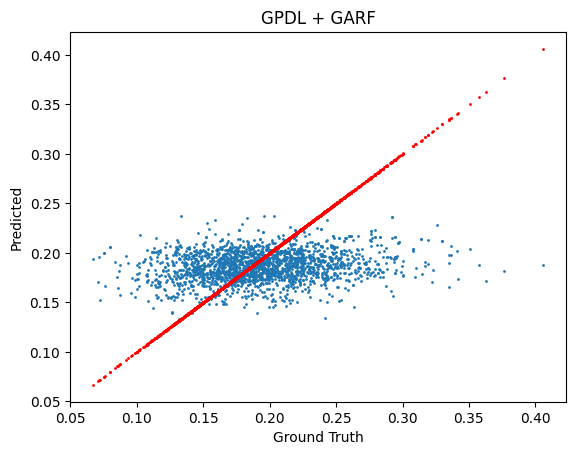

In [75]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.1932377924556714), pvalue=np.float64(6.703551318228731e-11)),
 'SRCC': SignificanceResult(statistic=np.float64(0.16557866367864385), pvalue=np.float64(2.4241362490778918e-08)),
 'KRCC': SignificanceResult(statistic=np.float64(0.11190743170702613), pvalue=np.float64(1.9933446014456854e-08)),
 'NDCG': np.float64(0.957925144893624)}

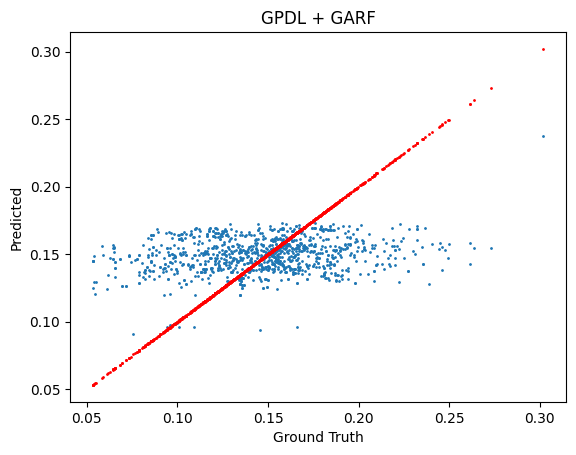

In [76]:
evaluate_design(test_df_b)

In [86]:
feat_pool = {
    'rudy_gradient_variability': 'the variation in gradient changes across the rudy map indicating potential areas of abrupt routing demand shifts',
    'clustered_macro_distance_std': 'the standard deviation of distances between clustered groups of macros',
    'rudy_pin_clustering_coefficient': 'a measure of how many rudy pins cluster together relative to the total number of rudy pins',
    'macro_density_gradient': 'the change in macro density across the layout, impacting local congestion',
    'macro_aspect_ratio_variance': 'the variance in aspect ratios of macros, indicating potential alignment and spacing issues that may impact congestion',
    'macro_compactness_index': 'a measure of how closely packed the macros are, potentially affecting routing paths and congestion',
    'rudy_pin_compaction_ratio': 'the ratio of compacted rudy pin clusters to the total number of rudy pins, indicating areas with high potential routing conflicts',
    'macro_variability_coefficient': 'a measure of the consistency in macro sizes and shapes relative to each other, potentially affecting congestion balance',
    'macro_symmetry_coefficient': 'a measure of the symmetry in macro placements relative to the overall layout, potentially influencing uniformity in congestion distribution',
    'macro_cluster_density_contrast': 'the contrast in density between clustered groups of macros and their surrounding layout areas, indicating potential localized congestion pressure',
    'rudy_pin_distribution_kurtosis': 'a measure of the peakedness or flatness in the distribution of rudy pins across the layout, indicating potential areas of concentrated or dispersed routing demand',
    'localized_rudy_variability_coefficient': 'a measure of the variation in RUDY intensity within localized regions, indicating potential micro-level congestion fluctuations',
    'macro_distribution_clarity_index': 'a measure of how distinct macro distributions are across the layout, indicating clarity in separation and potential influence on congestion distribution',
    'rudy_direction_consistency_index': 'a measure of the uniformity in the directional flow of RUDY intensity, indicating how consistent the routing demand is across the layout',
    'rudy_pin_area_masking_index': 'the ratio of the area masked by rudy pin regions relative to the total layout, indicating potential routing blockages',
    'rudy_pin_gradient_convergence': 'a measure of how gradients in the rudy pin map converge into specific regions, indicating high-density pin clusters',
    'rudy_intensity_symmetry_index': 'a measure of the symmetry in the RUDY intensity map across the layout, indicating uniformity in routing demand distribution',
    'rudy_deviation_effect_index': 'a measure of the deviation of RUDY intensities from the mean, indicating areas of abnormal routing demand',
    'demarcated_macro_proximity_index': 'a measure of how close macros are to predefined boundary regions, potentially affecting routing and congestion near layout edges',
    'macro_surface_irregularity_index': 'a measure of the irregularity in macro surface shapes, which can impact routing paths and layout clarity',
    'macro_rudy_boundary_interaction_index': 'a measure of the interaction between macros and high RUDY regions, indicating potential congestion hotspots',
    'pin_density_peak_contrast': 'the contrast between peak pin density regions and their surroundings, indicating areas of abrupt routing demand changes',
    'rudy_pin_density_flux_index': 'a measure of the rate of change in rudy pin density across the layout, indicating dynamic routing demand shifts',
    'high_density_rudy_ratio': 'the ratio of areas with high RUDY intensity to the total layout area, indicating overall routing demand hotspots',
    'high_density_rudy_pin_ratio': 'the ratio of areas with high RUDY pin intensity to the total layout area, indicating localized pin density hotspots'
}

In [87]:
feat_func_list = [
 rudy_gradient_variability,
 clustered_macro_distance_std,
 rudy_pin_clustering_coefficient,
 macro_density_gradient,
 macro_aspect_ratio_variance,
 macro_compactness_index,
 rudy_pin_compaction_ratio,
 macro_variability_coefficient,
 macro_symmetry_coefficient,
 macro_cluster_density_contrast,
 rudy_pin_distribution_kurtosis,
 localized_rudy_variability_coefficient,
 macro_distribution_clarity_index,
 rudy_direction_consistency_index,
 rudy_pin_area_masking_index,
 rudy_pin_gradient_convergence,
 rudy_intensity_symmetry_index,
 rudy_deviation_effect_index,
 demarcated_macro_proximity_index,
 macro_surface_irregularity_index,
 macro_rudy_boundary_interaction_index,
 pin_density_peak_contrast,
 rudy_pin_density_flux_index
]

In [88]:
feat_func_list

[<function __main__.rudy_gradient_variability(images)>,
 <function __main__.clustered_macro_distance_std(images)>,
 <function __main__.rudy_pin_clustering_coefficient(images)>,
 <function __main__.macro_density_gradient(images)>,
 <function __main__.macro_aspect_ratio_variance(images)>,
 <function __main__.macro_compactness_index(images)>,
 <function __main__.rudy_pin_compaction_ratio(images)>,
 <function __main__.macro_variability_coefficient(images)>,
 <function __main__.macro_symmetry_coefficient(images)>,
 <function __main__.macro_cluster_density_contrast(images)>,
 <function __main__.rudy_pin_distribution_kurtosis(images)>,
 <function __main__.localized_rudy_variability_coefficient(images)>,
 <function __main__.macro_distribution_clarity_index(images)>,
 <function __main__.rudy_direction_consistency_index(images)>,
 <function __main__.rudy_pin_area_masking_index(images)>,
 <function __main__.rudy_pin_gradient_convergence(images)>,
 <function __main__.rudy_intensity_symmetry_index(